In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from libs import customplots as cplot
from libs.utils import round_sig_figs

## Summary stats

In [3]:
ppe = pd.read_csv('data/PPE.csv')
df = pd.read_csv('data/AIS_PPE_control_ensemble_SLC.csv', index_col=0, dtype=float)

weird_runs = [20, 34, 52, 62, 70, 74, 78, 87, 103, 114]

slc = df.T[9990]

min = slc.min()
max = slc.max()
median = np.median(slc)
mean = np.mean(slc)
std = np.std(slc)

print(
    f'{min = :.2f}',
    f'{max = :.2f}',
    f'{median = :.2f}',
    f'{mean = :.2f} ± {std:.2f}',
    sep='\n'
)

total = len(slc)
gt0 = (slc > 0).sum()
pct = round(100*gt0/total, 1)

print(
    f'{gt0} with sea level rise ({pct}%)',
    f'{total-gt0} with sea level fall ({100-pct}%)',
    sep='\n'
)

min = -15.66
max = 23.50
median = -3.79
mean = -1.49 ± 9.06
38 with sea level rise (31.7%)
82 with sea level fall (68.3%)


## Timeseries

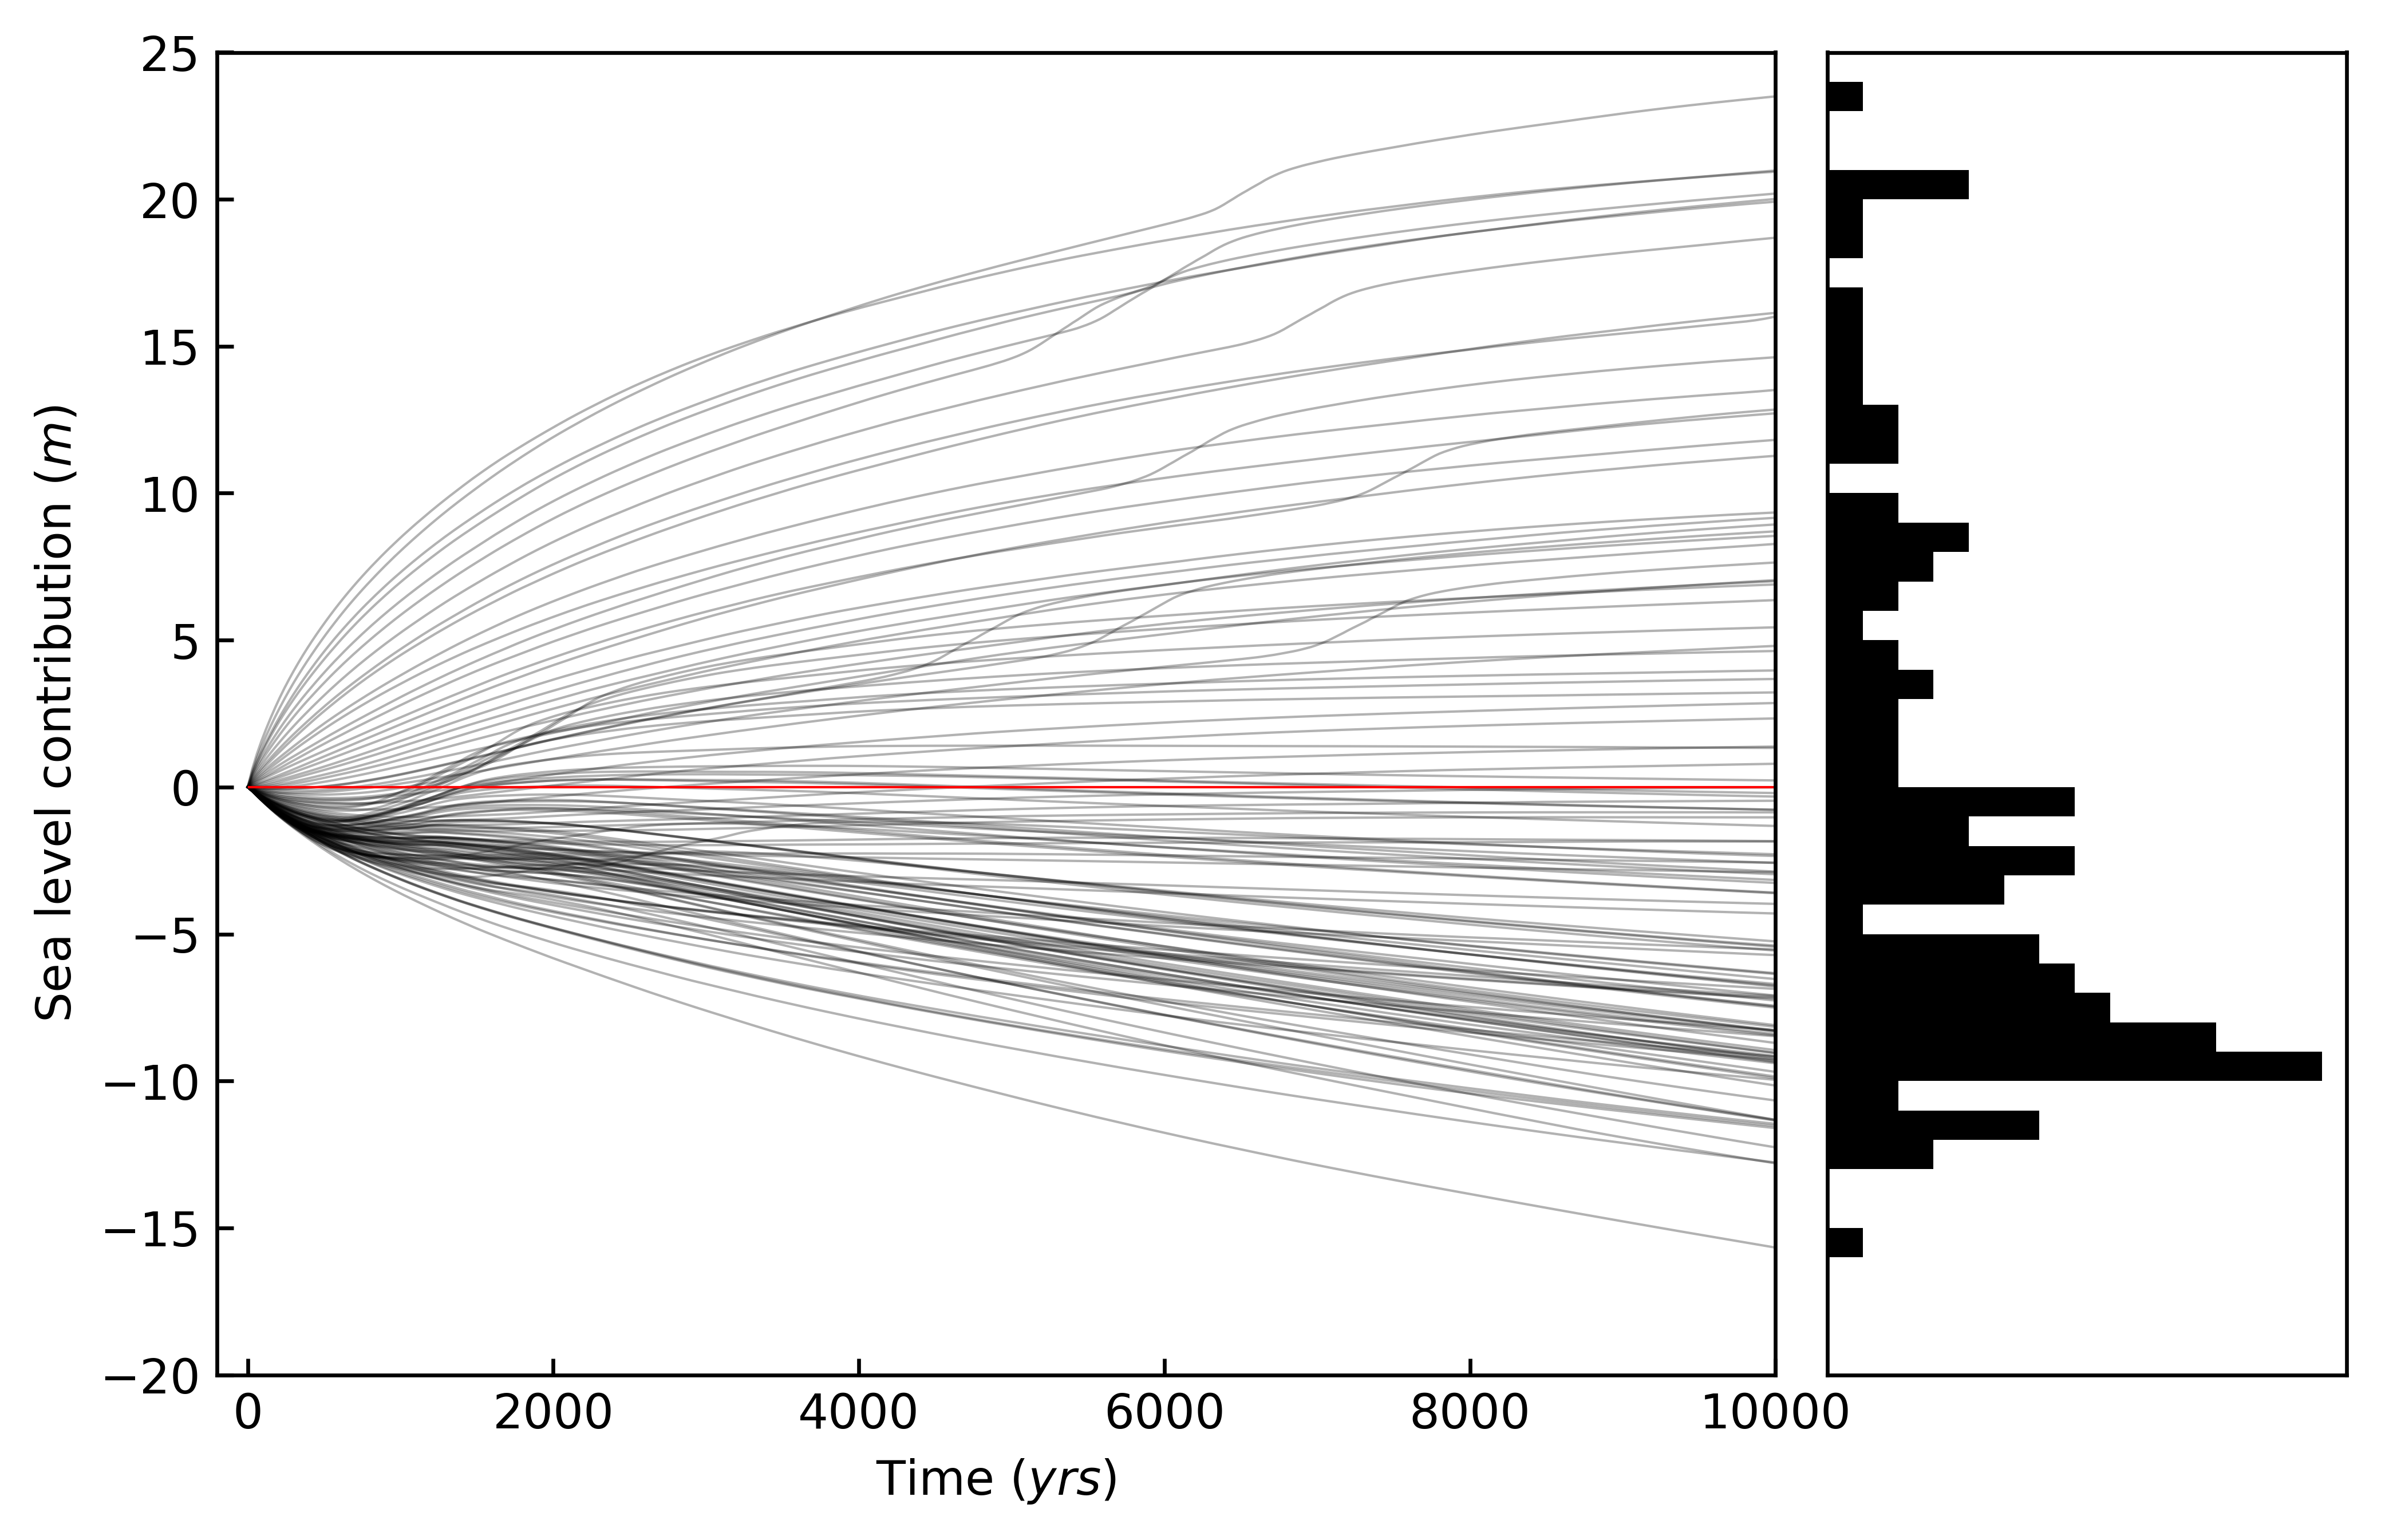

In [9]:
fig = cplot.ts_with_hist(
    df,
    color='black',
    lw=0.5,
    ylabel='Sea level contribution ($m$)',
    ylim = (-20, 25),
    alpha=0.3
    )

## Extrapolated Timeseries

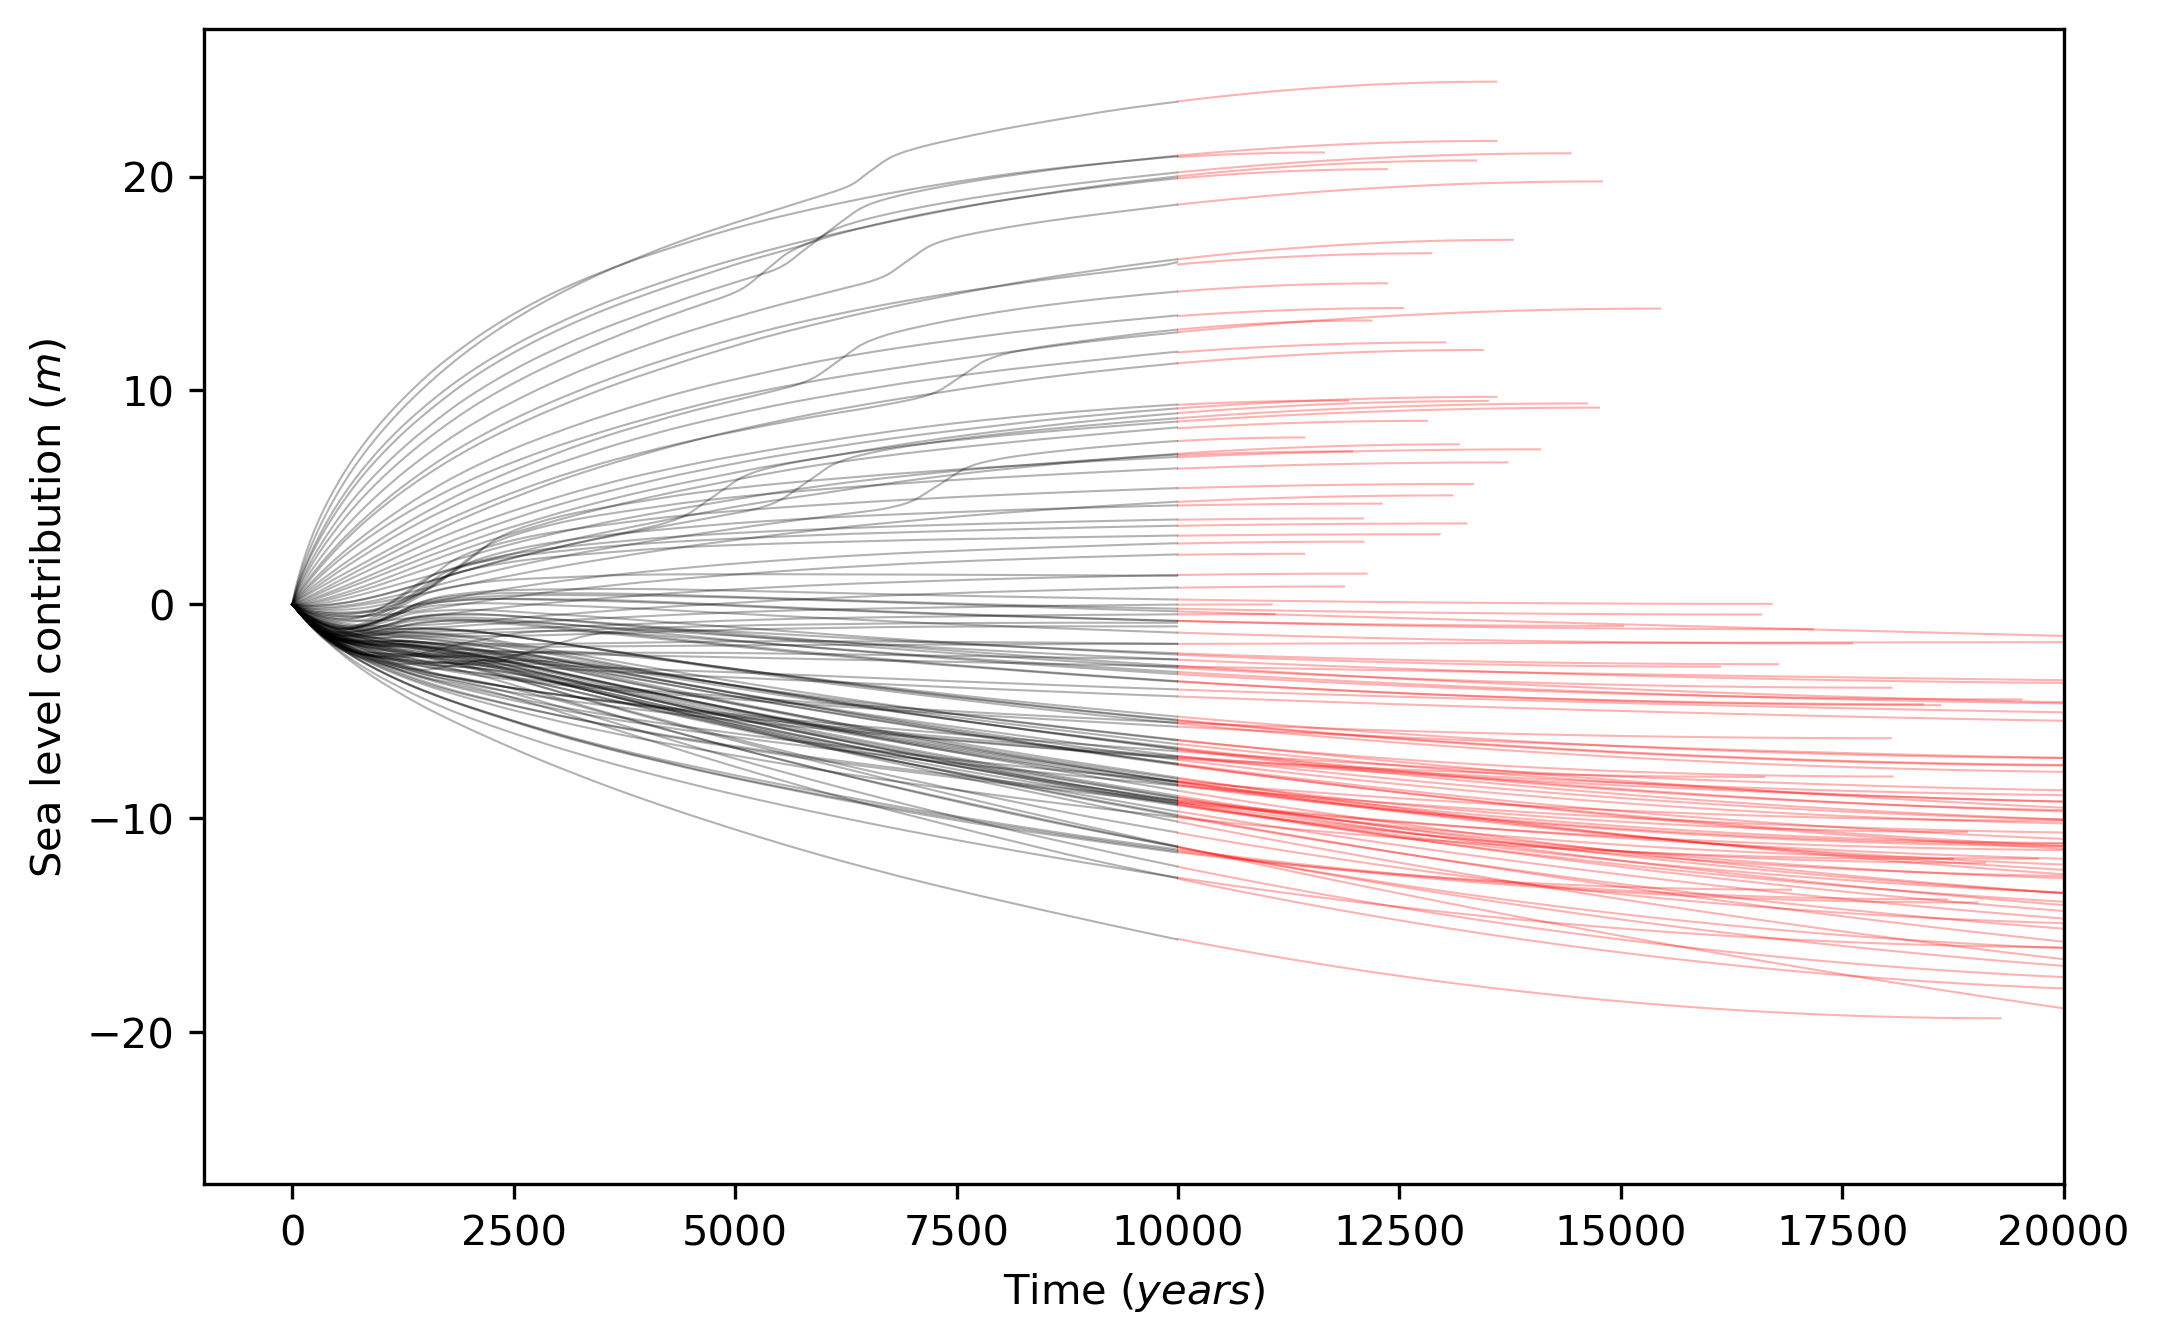

In [10]:
fig, ax = mpl.pyplot.subplots(figsize=(8, 5), dpi=300)

years = np.arange(0, 10020, 30)

def quadratic(x, a, b, c):
    return a*(x-b)**2 + c

def asymptotic(x, a, b, n):
    return a * x ** n  / (x ** n + b)

for i, run_num in enumerate(df):
    run = df[run_num]
    ax.plot(years, run, c='black', alpha=0.3, lw=0.5)
    ax.set_ylabel('Sea level contribution ($m$)')
    ax.set_xlabel('Time ($years$)')

    if int(run_num) not in weird_runs:
        start_year=5000
    else:
        start_year=8000
    fit_years = np.arange(start_year, 9990, 30)
    fit_data = run[run.index > start_year]

    poly = np.polyfit(fit_years, fit_data, deg=2)
    a, b, c = poly
    end_year = -b/(2*a)
    if end_year < 10_000:
        continue

    #asymp, _ = curve_fit(asymptotic, fit_years, fit_data)

    years_extrap = np.linspace(10_000, end_year, 100)
    extrapolation = np.polyval(poly, years_extrap)

    ax.plot(years_extrap, extrapolation, c='red', alpha=0.3, lw=0.5)
    ax.set_xlim([-1000, 20000])

    #popt, pcov = curve_fit(asymptotic, fit_years, fit_data, p0=[1., 5000., 1.])

    fig.savefig('plots/png/control_ensemble_extrap.png', format='png')

## Equilibrium vs Transient

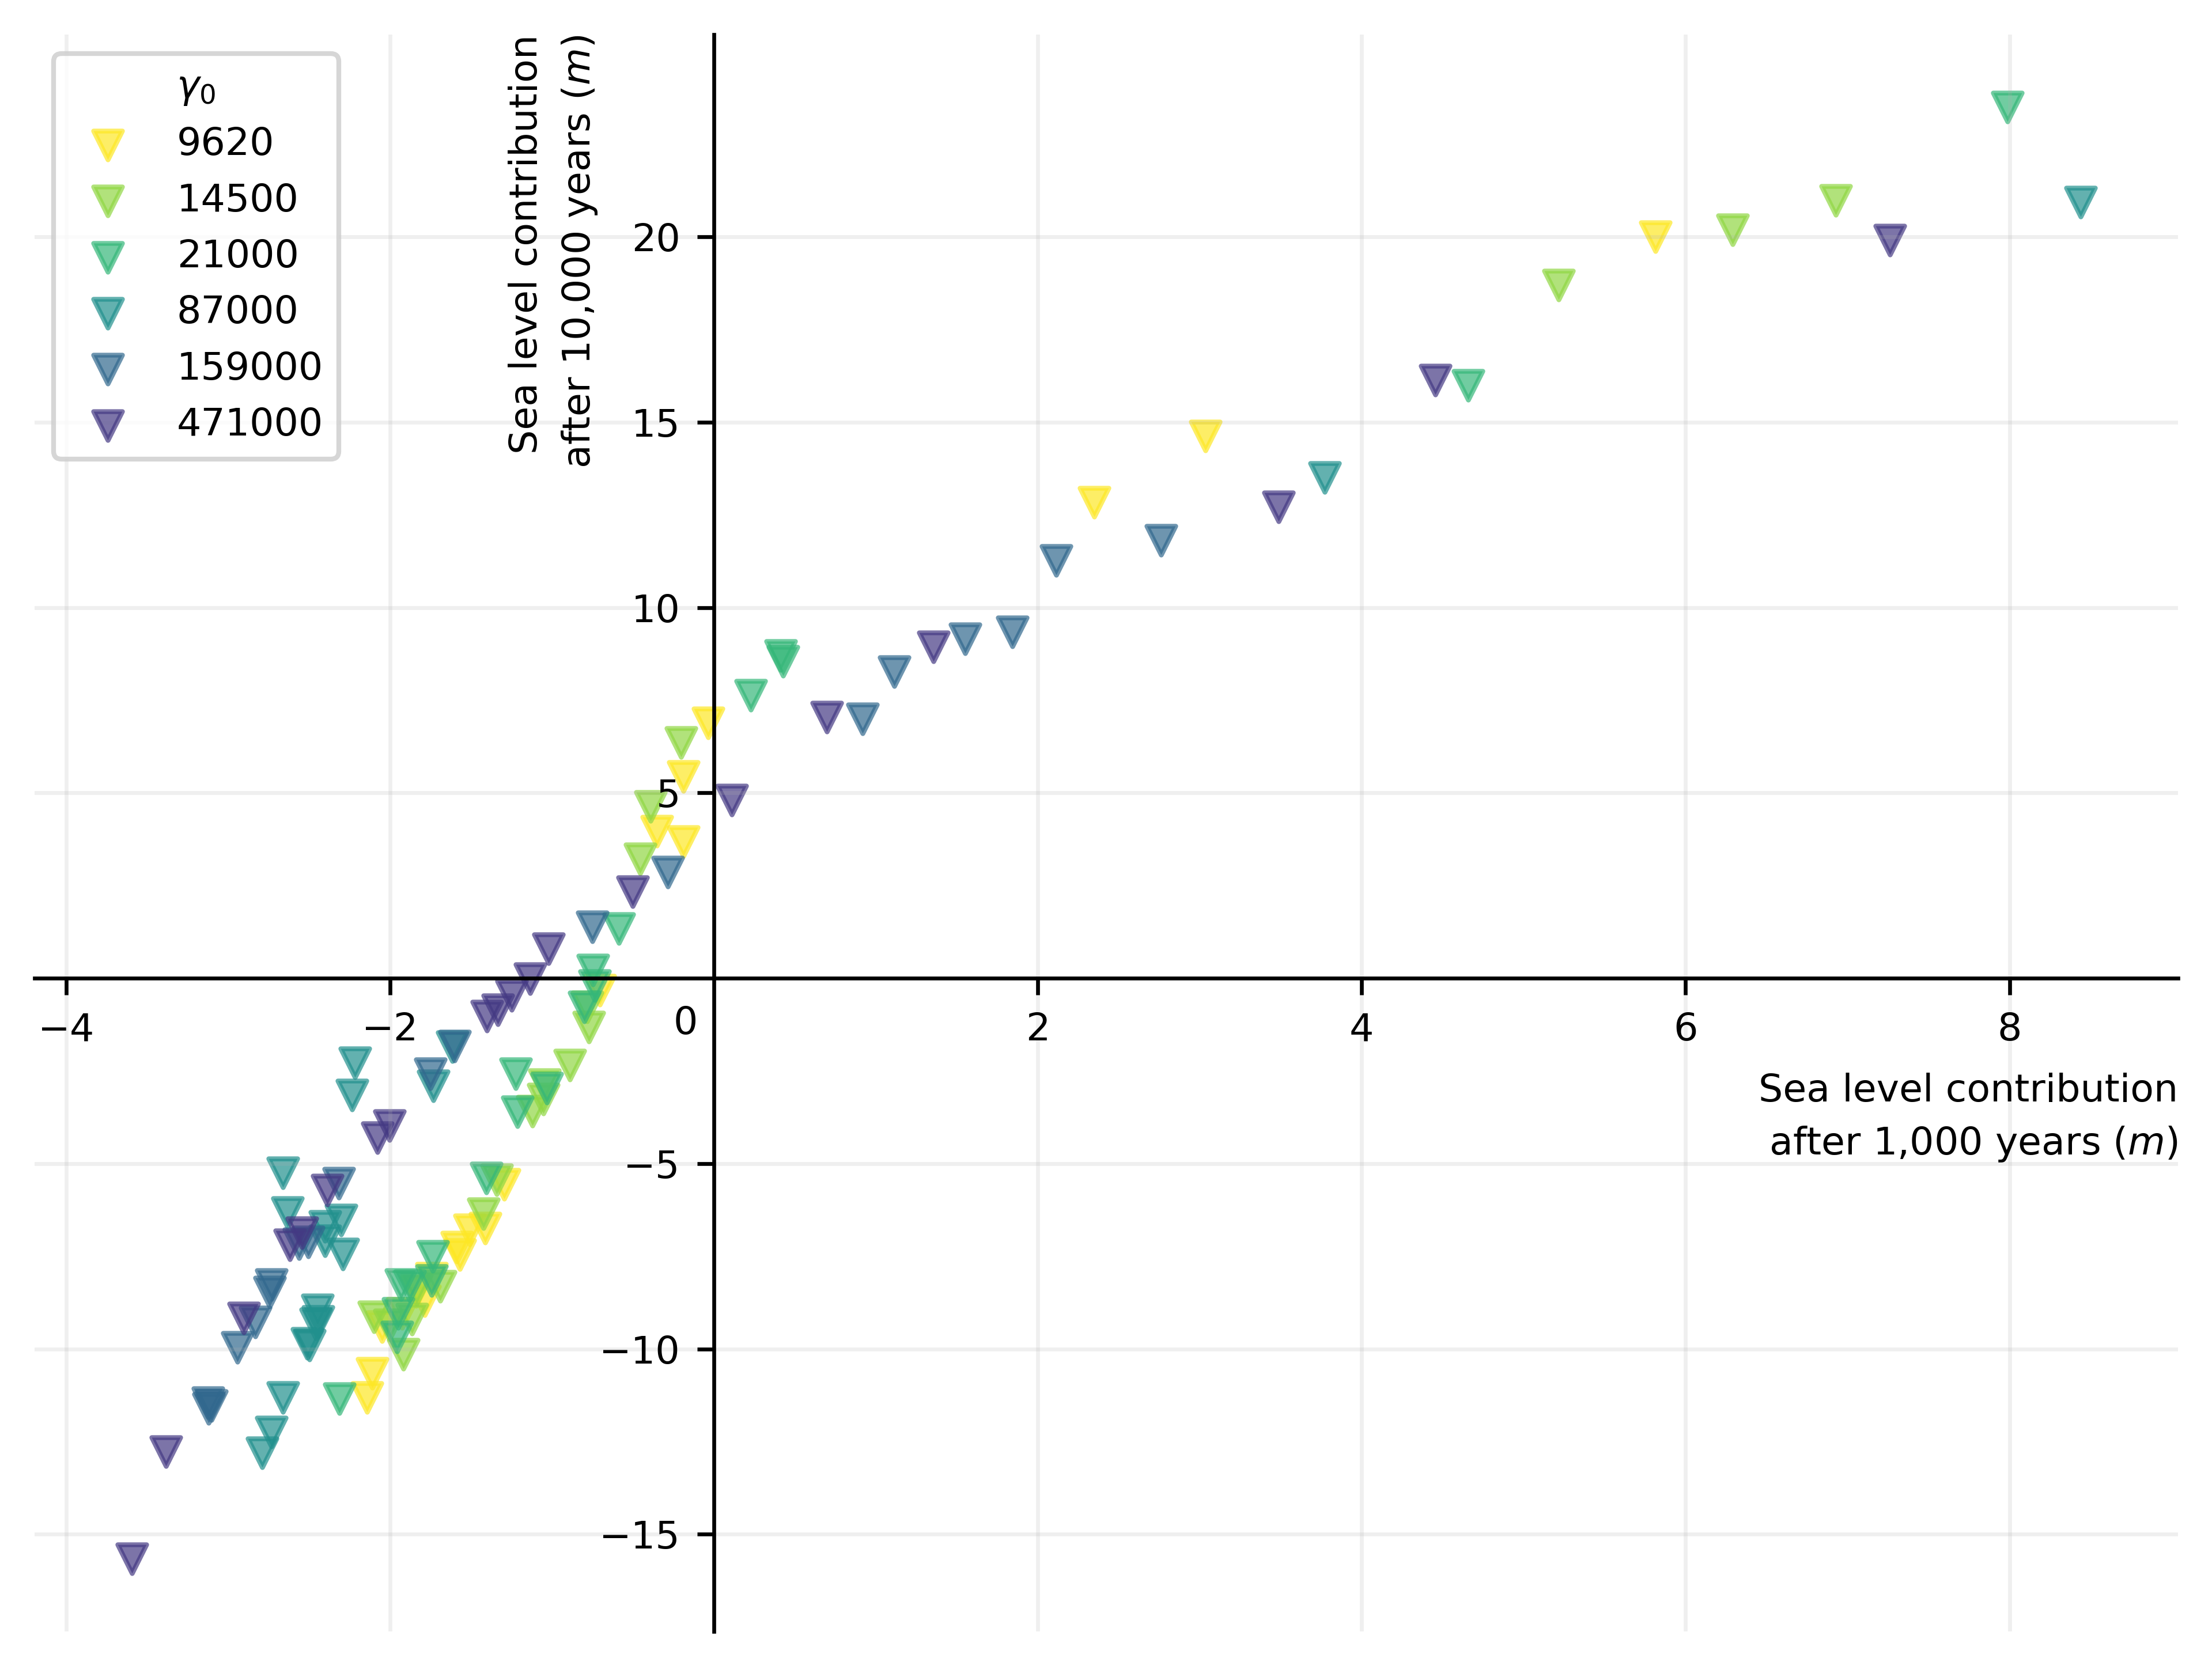

In [39]:
font = {'size': 8}
mpl.rc('font', **font)

fig, ax = mpl.pyplot.subplots(figsize=(8, 6), dpi=600)

unique_gamma_values = sorted(ppe['gamma0'].unique())
gamma_colors = mpl.cm.viridis_r([i / len(unique_gamma_values) for i in range(len(unique_gamma_values))])
gamma_color_map = {gamma_value: gamma_colors[i] for i, gamma_value in enumerate(unique_gamma_values)}

dft = df.T
dft.index=range(120)
for i, gamma_value in enumerate(unique_gamma_values):
    gamma_df = dft[ppe['gamma0'] == gamma_value]
    ax.scatter(
        gamma_df[990.0], 
        gamma_df[9990.0], 
        color=gamma_color_map[gamma_value], 
        label=f'{int(round_sig_figs(gamma_value, 3))}',
        marker='v',
        alpha=0.7
        )

for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')

ax.grid(alpha=0.2)
legend = ax.legend(title='$\gamma_0$', loc='upper left')
ax.set_xticks([-4, -2, 2, 4, 6, 8])
ax.set_yticks([-15, -10, -5, 5, 10, 15, 20])

ax.set_xlabel('Sea level contribution\n after 1,000 years ($m$)', loc='right', labelpad=5, linespacing=1.5)
ax.set_ylabel('Sea level contribution\n after 10,000 years ($m$)', loc='top', labelpad=0, linespacing=1.5)
ax.text(-0.25, -1.5, '0')

mpl.pyplot.savefig('plots/svg/transientVsequilibrium.svg', format='svg')
mpl.pyplot.savefig('plots/png/transientVsequilibrium.png', format='png')

## Sensitivity

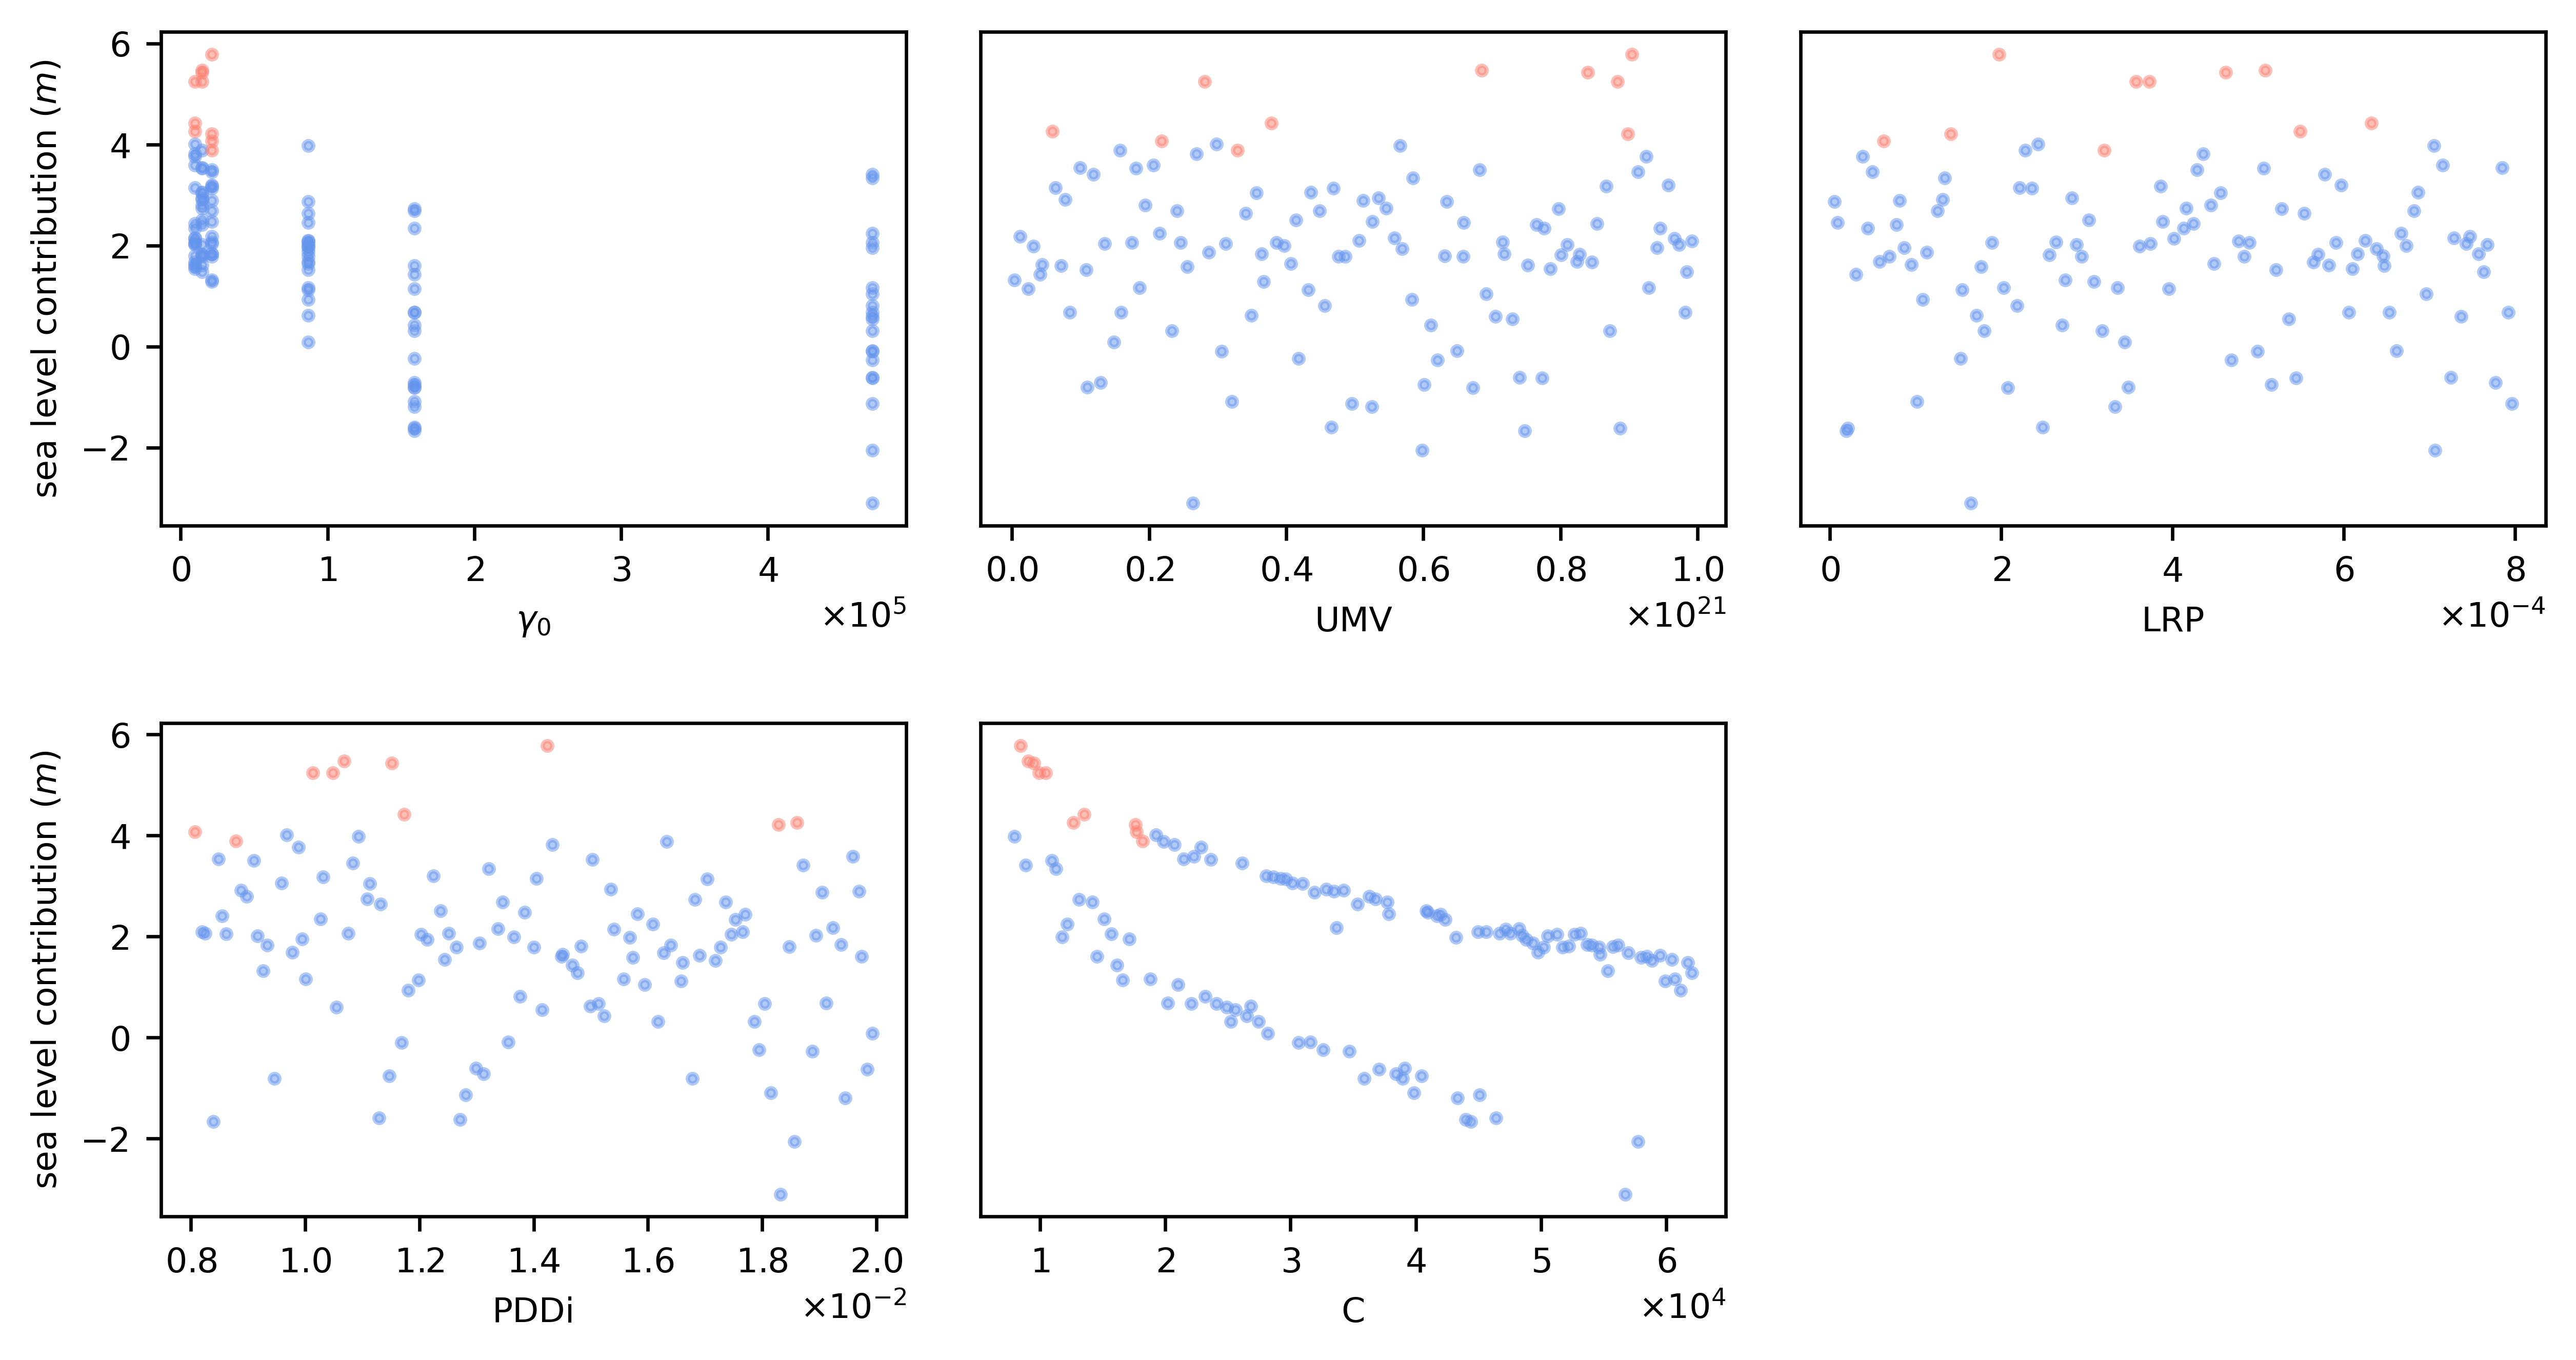

In [12]:
font = {'size': 8}
mpl.rc('font', **font)

parameters = ['gamma0', 'UMV', 'LRP', 'PDDi', 'WeertC']
relabel = {
    'gamma0': '$\gamma_0$',
    'WeertC': 'C'
}
slc.index = range(1, 121)
mask = slc.index.isin(weird_runs)
cplot.sensitivity(ppe[parameters], slc, mask=mask, relabel=relabel, colors=['cornflowerblue', 'salmon'], s=5, alpha=0.5)

mpl.pyplot.savefig('plots/svg/sensitivity_main.svg', format='svg')
mpl.pyplot.savefig('plots/png/sensitivity_main.png', format='png')

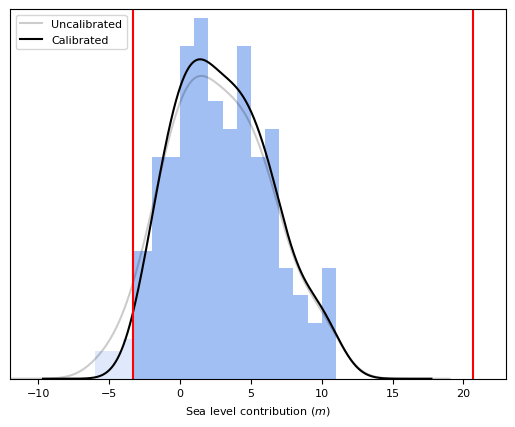

In [13]:
fig, ax = mpl.pyplot.subplots()

summary = pd.read_csv('data/pliocene_summary.csv')

bins=np.linspace(-3.3, 20.7, 20)
diff = bins[1]-bins[0]
new_min_bin = bins[0]-3*diff

bins = np.arange(new_min_bin, 20.7+diff, diff)
bins = [-17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3.3, -2, -1, 0, 1, 2, 3, 4,\
         5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20.7, 22, 23, 24, 25, 26, 27, 28]
n, bins, patches = ax.hist(summary['Plio_minus_ctrl'], bins=bins, density=True, alpha=0.6)

# Set alpha conditionally for bars with x coordinate less than -3
for i in range(len(bins)-1):
    if bins[i] < -3.3:
        patches[i].set_alpha(0.2)

summary['Plio_minus_ctrl'].plot.kde(color='black', label='Uncalibrated', alpha=0.2)
summary[summary['Plio_minus_ctrl']>-3]['Plio_minus_ctrl'].plot.kde(color='black', label='Calibrated')

ax.legend(loc = 'upper left')
ax.get_yaxis().set_visible(False)
ax.set_xlim(-12, 23)
ax.set_ylim(0, 0.12)

ax.vlines(-3.3, 0, 0.12, color='red')
ax.vlines(20.7, 0, 0.12, color='red')

ax.set_xlabel('Sea level contribution ($m$)')

mpl.pyplot.savefig('plots/svg/pliominusctrl.svg', format='svg')
mpl.pyplot.savefig('plots/png/pliominusctrl.png', format='png')

In [14]:
min = summary['Plio_minus_ctrl'].min()
max = summary['Plio_minus_ctrl'].max()
mean = summary['Plio_minus_ctrl'].mean()
sdt = summary['Plio_minus_ctrl'].std()
median = summary['Plio_minus_ctrl'].median()

print(min, max, mean, sdt, median, sep='\n')

-5.355443268738638
10.885869710873497
2.71590846284614
3.571899640666879
2.4764756131523136


In [15]:
np.sum(summary['Plio_minus_ctrl']>-3.3)

108

In [16]:
mask = summary['Plio_minus_ctrl']>-3.3
calibrated = summary['Plio_minus_ctrl'][mask]
print(calibrated.mean())
print(calibrated.std())
print(calibrated.median())

2.9227975872669485
3.3921051038233396
2.5799646521224275


In [17]:
summarycsv = pd.read_csv('/Users/jonniebarnsley/Downloads/Pliocene summary data - PLIO_PPE_results_df(1).csv')
summarycsv

Run  Unnamed: 0  expNum         gamma0           UMV       LRP      PDDi  \
0      0         119       1    9618.882299  2.060000e+20  0.000716  0.019590   
1      1          80       2  159188.541400  7.970000e+20  0.000527  0.016819   
2      2          50       3  159188.541400  2.370000e+19  0.000396  0.011979   
3      3          25       4  471264.291700  6.490000e+20  0.000662  0.013550   
4      4          76       5  159188.541400  3.210000e+20  0.000102  0.018149   
..   ...         ...     ...            ...           ...       ...       ...   
115  115          90     116  471264.291700  2.150000e+20  0.000667  0.016084   
116  116          93     117   21005.343640  9.570000e+20  0.000597  0.012239   
117  117          20     118    9618.882299  9.250000e+20  0.000039  0.009879   
118  118          19     119   21005.343640  3.120000e+20  0.000743  0.012031   
119  119          59     120    9618.882299  4.370000e+19  0.000095  0.016902   

          WeertC  modelNum   model  ... Wilkes_PorF_5k  Wilkes_AC_10k  \
0    22300.78404         1  cosmos  ...           Fail   7.680000e+08   
1    13110.00177         1  cosmos  ...           Fail   1.792000e+09   
2    16585.21943         1  cosmos  ...           Fail   1.536000e+09   
3    31568.73903         1  cosmos  ...           Pass  -7.526400e+10   
4    39836.39122         1  cosmos  ...           Fail  -5.632000e+09   
..           ...       ...     ...  ...            ...            ...   
115  12164.39133         4  hadcm3  ...            NaN            NaN   
116  28079.55828         4  hadcm3  ...           Fail   3.584000e+09   
117  22846.37812         4  hadcm3  ...           Fail   4.352000e+09   
118  51296.82688         4  hadcm3  ...           Pass  -1.013760e+11   
119  59499.83164         4  hadcm3  ...           Pass  -1.536000e+10   

     Wilkes_AC_5k  main_minus_ctrle_10k  prism_minus_ctrle_10k  SLC_PorF_10k  \
0    7.680000e+08                   NaN                    NaN          Pass   
1    1.792000e+09                   NaN                    NaN          Pass   
2    1.536000e+09                   NaN                    NaN          Pass   
3   -7.526400e+10                   NaN                    NaN          Pass   
4   -5.632000e+09                   NaN                    NaN          Fail   
..            ...                   ...                    ...           ...   
115           NaN                   NaN                    NaN           NaN   
116  3.584000e+09                   NaN                    NaN          Pass   
117  4.352000e+09                   NaN                    NaN          Pass   
118 -1.013760e+11              8.833182              17.091238          Pass   
119 -1.536000e+10              1.869875              16.487671          Fail   

     DoubleCal_PorF_10k  SLC_minus_ctrle_PorF_10k  \
0                  Fail                       NaN   
1                  Fail                       NaN   
2                  Fail                       NaN   
3                  Pass                       NaN   
4                  Fail                       NaN   
..                  ...                       ...   
115                 NaN                       NaN   
116                Fail                       NaN   
117                Fail                       NaN   
118                Pass                      Pass   
119                Fail                      Pass   

     DoubleCal_minus_ctrle_PorF_10k  DoubleCal_minus_ctrle_PorF_5k  
0                               NaN                            NaN  
1                               NaN                            NaN  
2                               NaN                            NaN  
3                               NaN                            NaN  
4                               NaN                            NaN  
..                              ...                            ...  
115                             NaN                            NaN  
116  

In [18]:
retreat = summarycsv['Wilkes_AC_10k']
sum = pd.read_csv('data/pliocene_summary.csv')
sum['Wilkes_retreat'] = retreat

In [19]:
sum

Unnamed: 0  expNum         gamma0           UMV       LRP      PDDi  \
0             0       1    9618.882299  2.057769e+20  0.000716  0.019590   
1             1       2  159188.541441  7.970285e+20  0.000527  0.016819   
2             2       3  159188.541441  2.365918e+19  0.000396  0.011979   
3             3       4  471264.291708  6.490640e+20  0.000662  0.013550   
4             4       5  159188.541441  3.211577e+20  0.000102  0.018149   
..          ...     ...            ...           ...       ...       ...   
115         115     116  471264.291708  2.146118e+20  0.000667  0.016084   
116         116     117   21005.343638  9.570742e+20  0.000597  0.012239   
117         117     118    9618.882299  9.249898e+20  0.000039  0.009879   
118         118     119   21005.343638  3.116500e+20  0.000743  0.012031   
119         119     120    9618.882299  4.373735e+19  0.000095  0.016902   

           WeertC   model   Pliocene    Control  Plio_minus_ctrl  \
0    22300.784043  cosmos   6.225787   3.967440         2.258347   
1    13110.001766  cosmos  16.312585  11.810203         4.502383   
2    16585.219430  cosmos  10.733773   7.002231         3.731542   
3    31568.739031  cosmos   6.058107  -4.300125        10.358232   
4    39836.391217  cosmos  -4.943914  -9.267447         4.323533   
..            ...     ...        ...        ...              ...   
115  12164.391333  hadcm3        NaN  12.714530              NaN   
116  28079.558275  hadcm3   1.566160   0.226333         1.339827   
117  22846.378123  hadcm3   1.127536   3.678539        -2.551003   
118  51296.826880  hadcm3  -2.916010  -7.500984         4.584974   
119  59499.831637  hadcm3 -16.671259 -11.315816        -5.355443   

     Wilkes_retreat  
0      7.680000e+08  
1      1.792000e+09  
2      1.536000e+09  
3     -7.526400e+10  
4     -5.632000e+09  
..              ...  
115             NaN  
116    3.584000e+09  
117    4.352000e+09  
118   -1.013760e+11  
119   -1.536000e+10  

[120 rows x 12 columns]

Text(0, 0.5, 'sea level contribution (Plio - Ctrl) (m)')

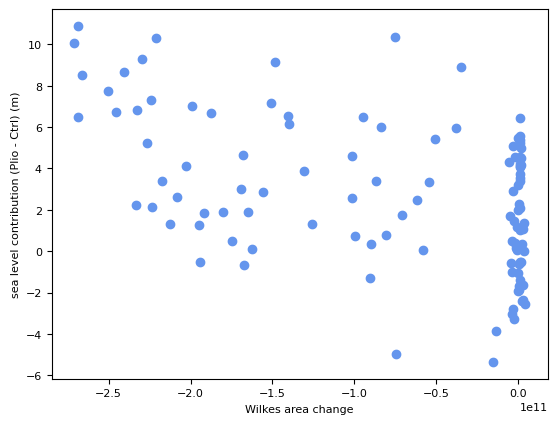

In [20]:
fig, ax = mpl.pyplot.subplots()

ax.scatter(sum['Wilkes_retreat'], sum['Plio_minus_ctrl'])
ax.set_xlabel('Wilkes area change')
ax.set_ylabel('sea level contribution (Plio - Ctrl) (m)')

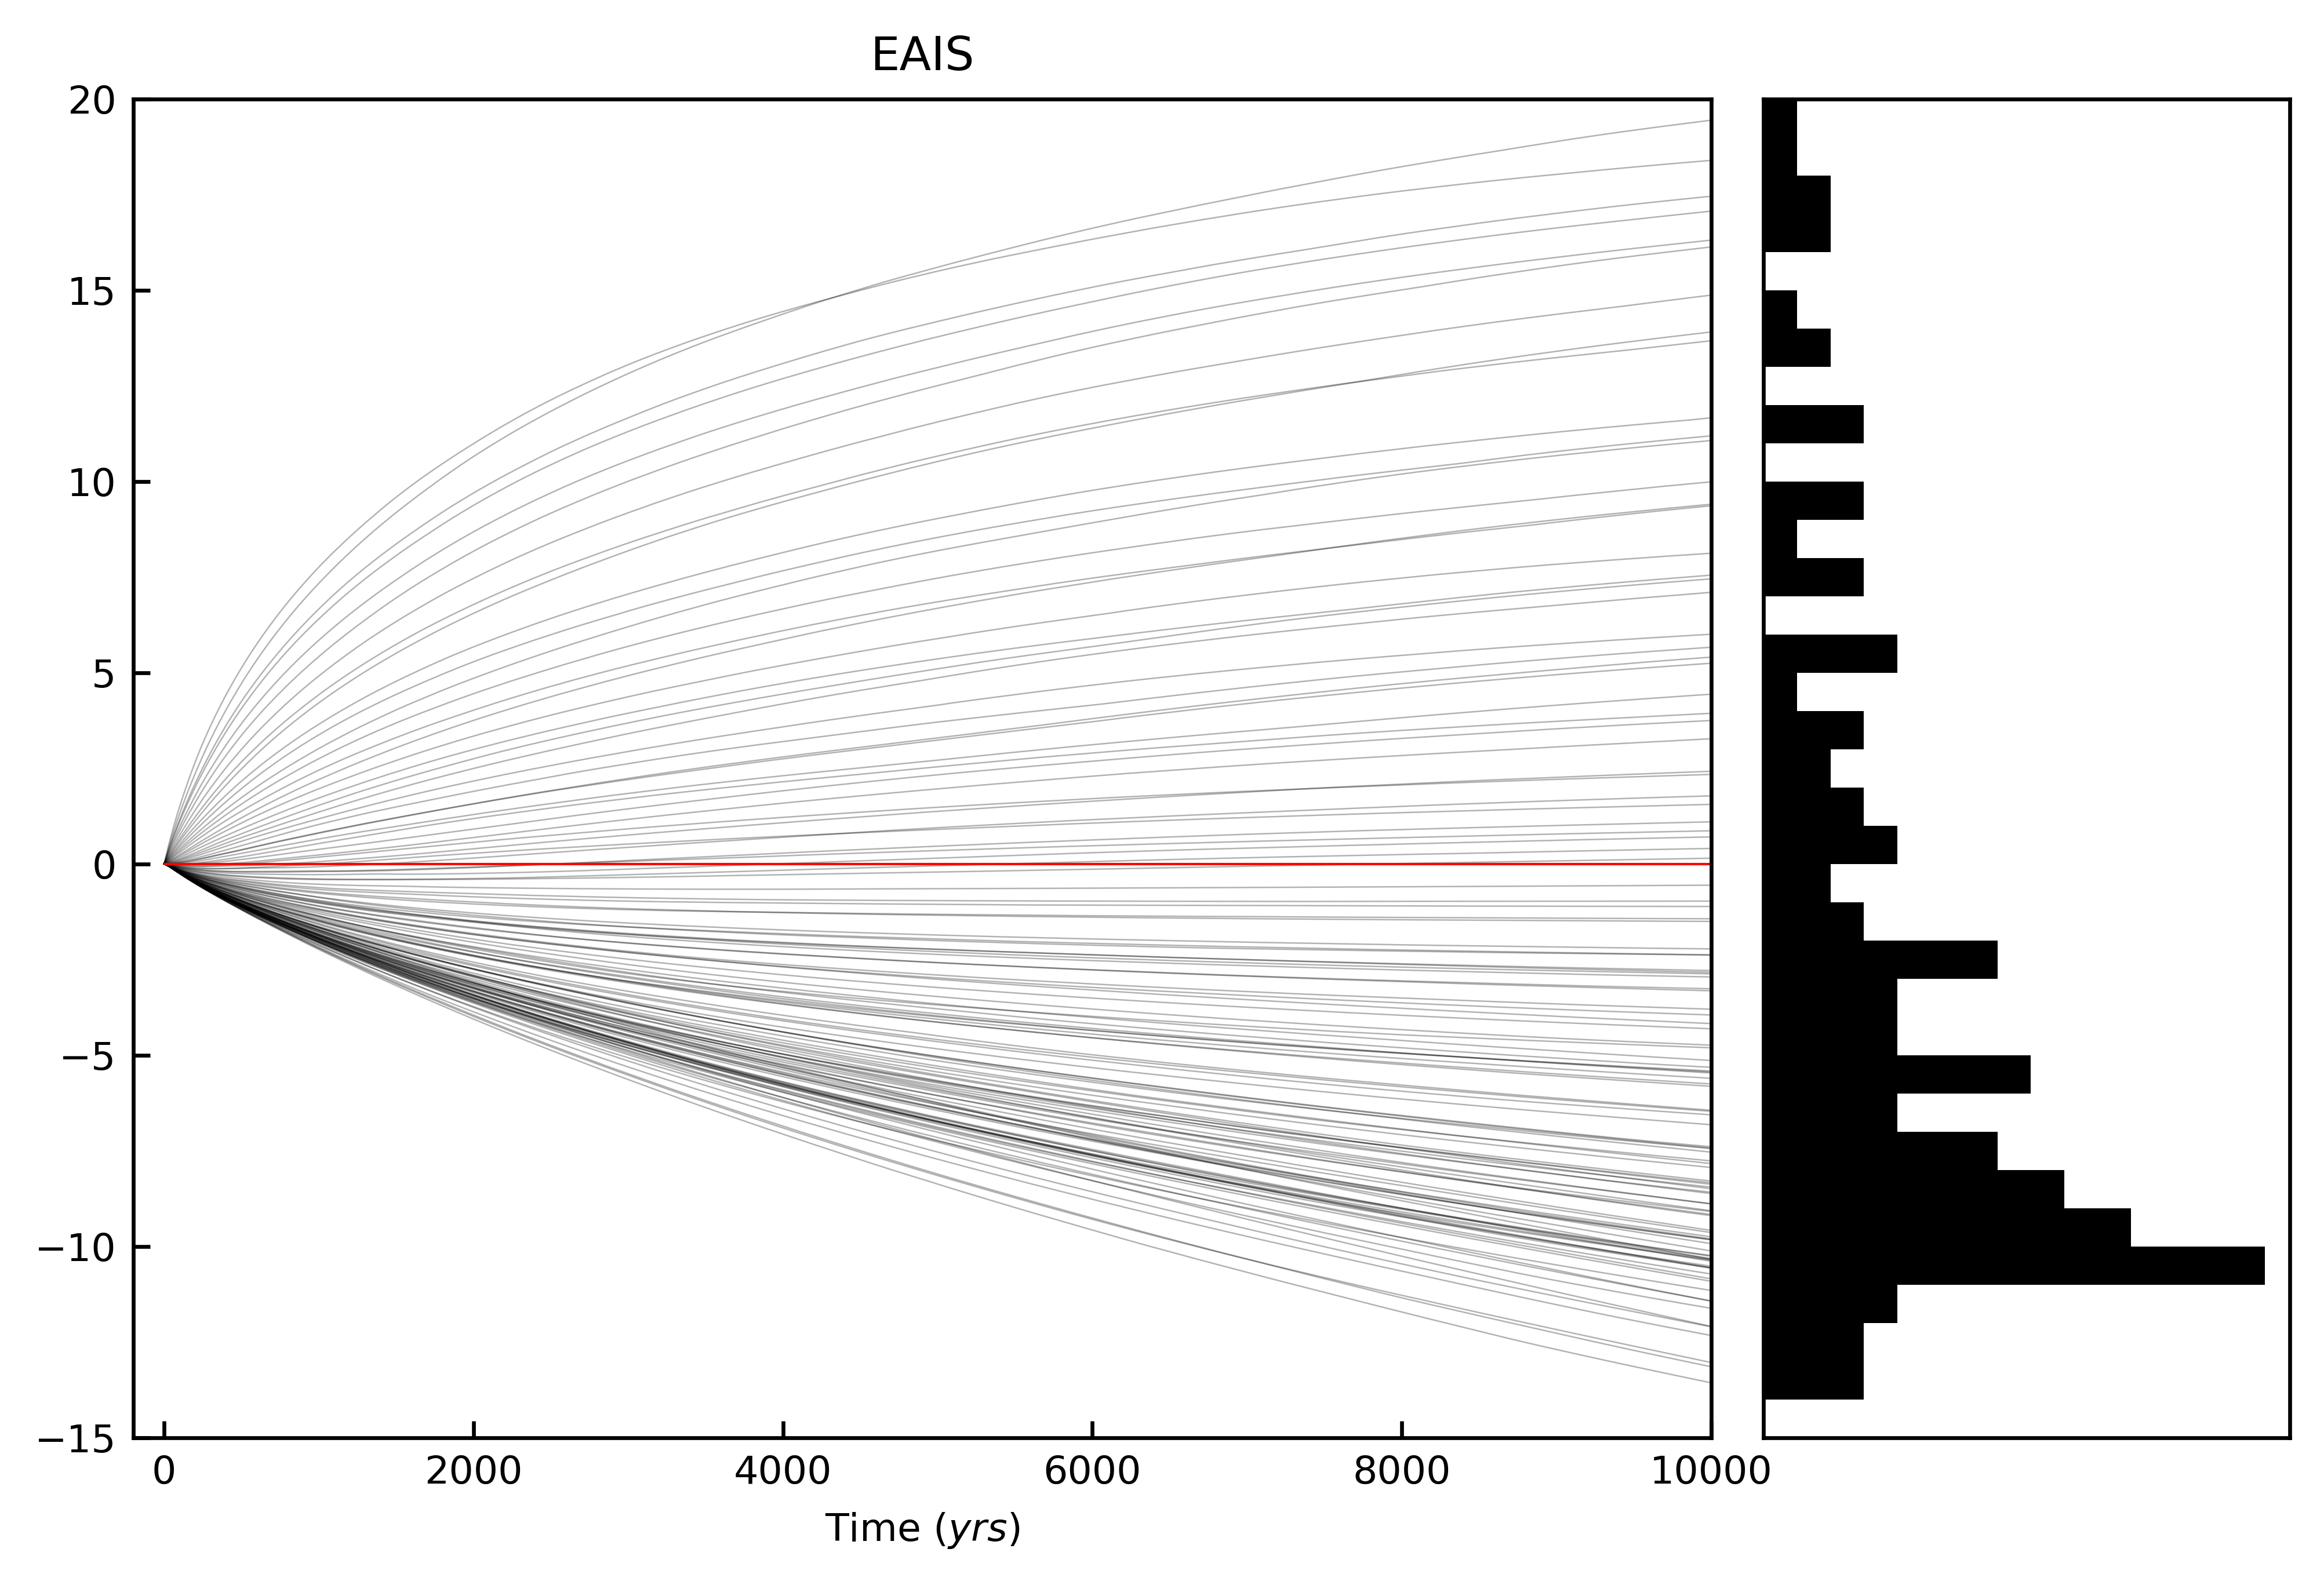

In [69]:
eais = pd.read_csv('ARC/data/AIS_PPE_control_ensemble_EAIS.csv', index_col=0, dtype=float)
eais.index = np.arange(0, 10_000, 30)
cplot.ts_with_hist(eais, bin_width=1, title='EAIS', ylim=[-15, 20])

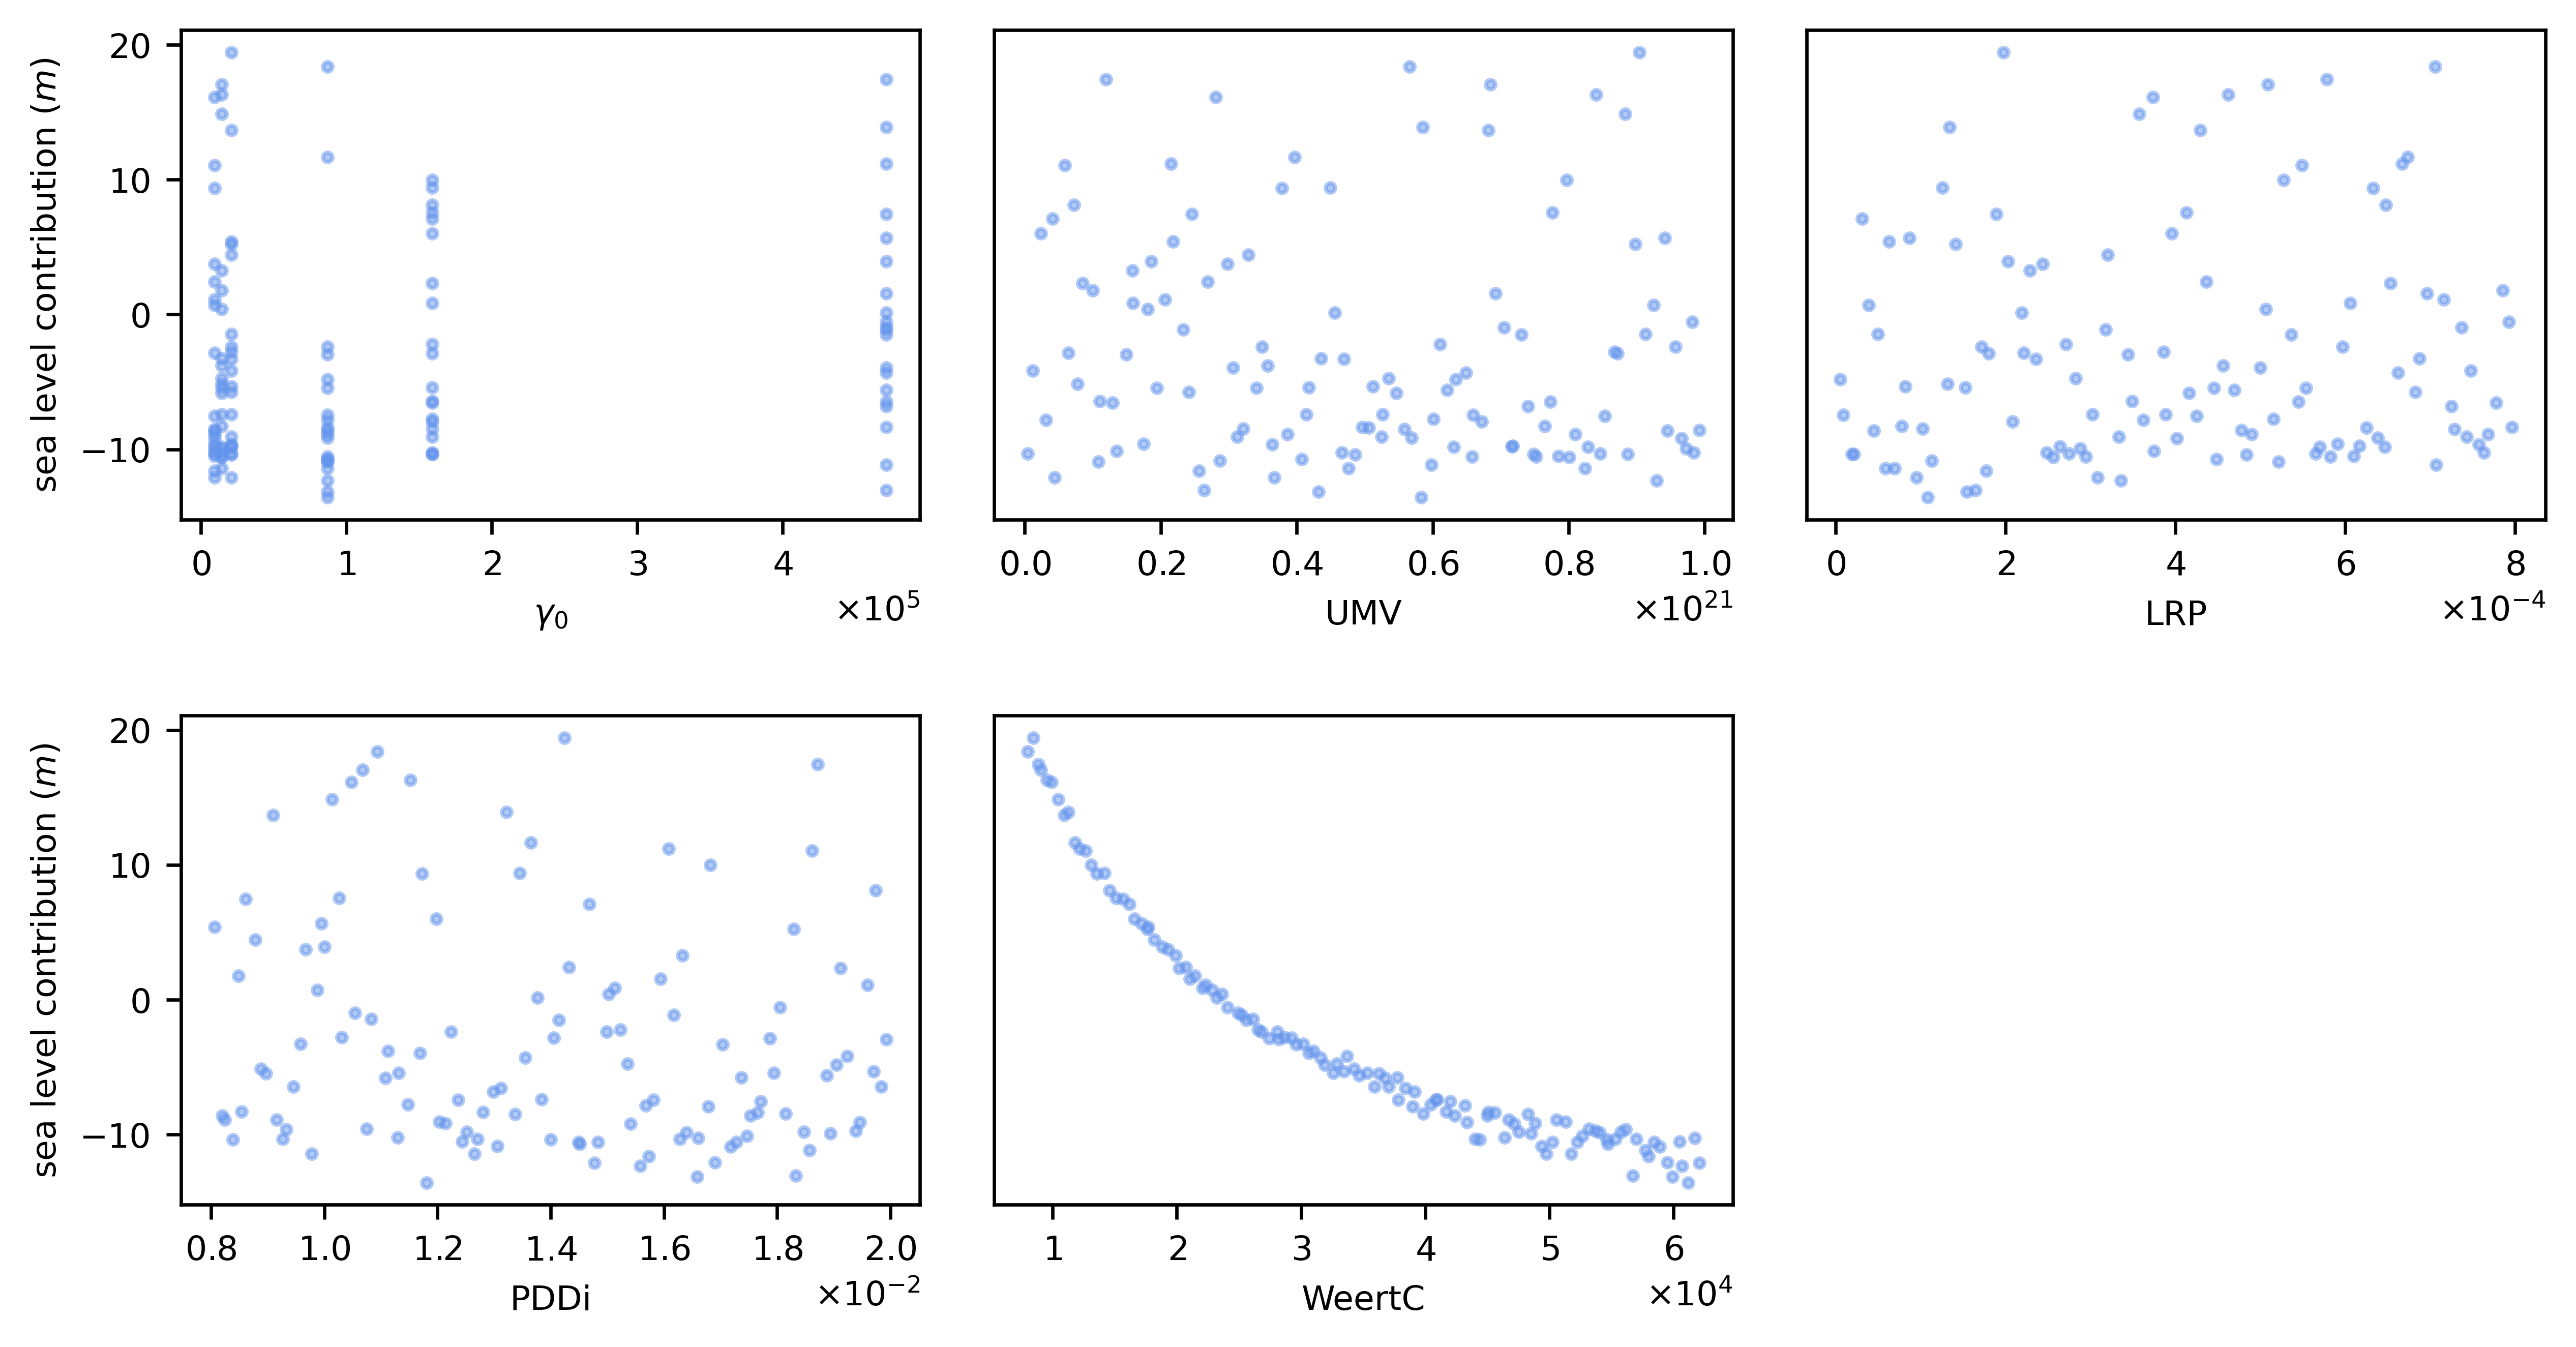

In [61]:
slc = eais.T[333.0]
relabel = {'gamma0': '$\gamma_0$'}
cplot.sensitivity(ppe[parameters], slc, s=5, alpha=0.5, relabel=relabel, color='cornflowerblue')

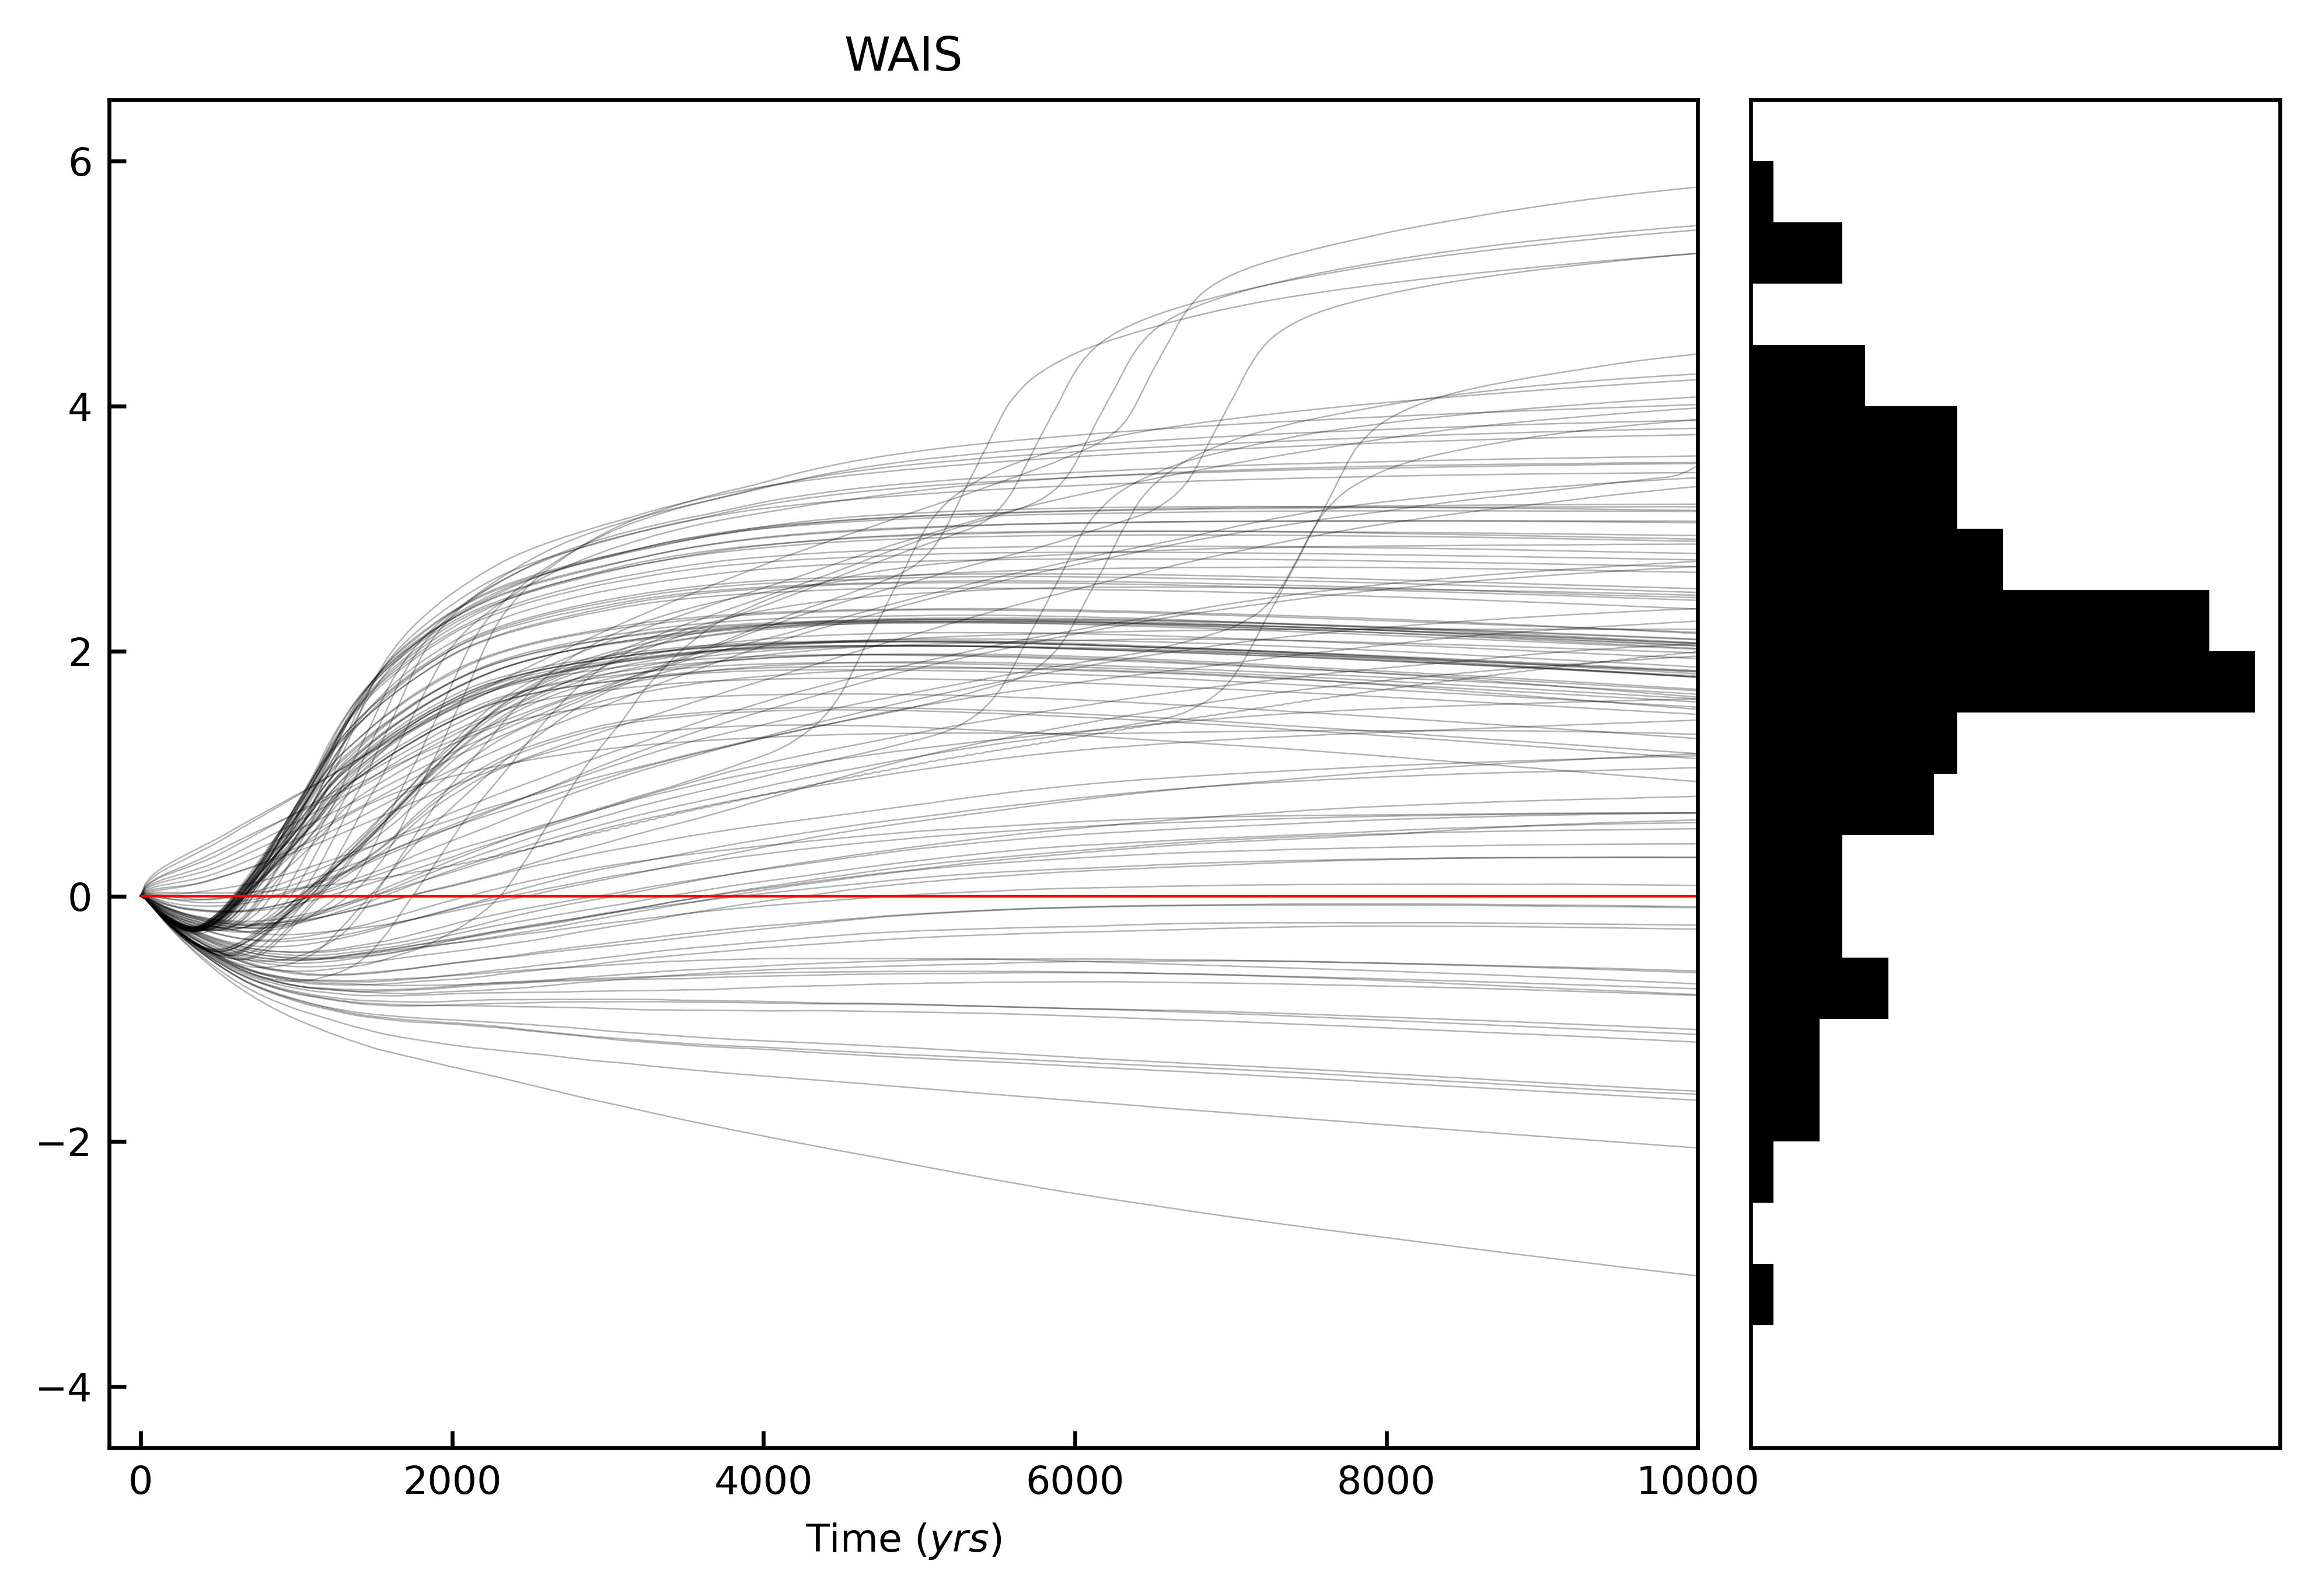

In [72]:
wais = pd.read_csv('ARC/data/AIS_PPE_control_ensemble_WAIS.csv', index_col=0, dtype=float)
wais = wais[wais.index <= 333.0]
wais.index = np.arange(0, 10_000, 30)
cplot.ts_with_hist(wais, bin_width=0.5, title='WAIS')

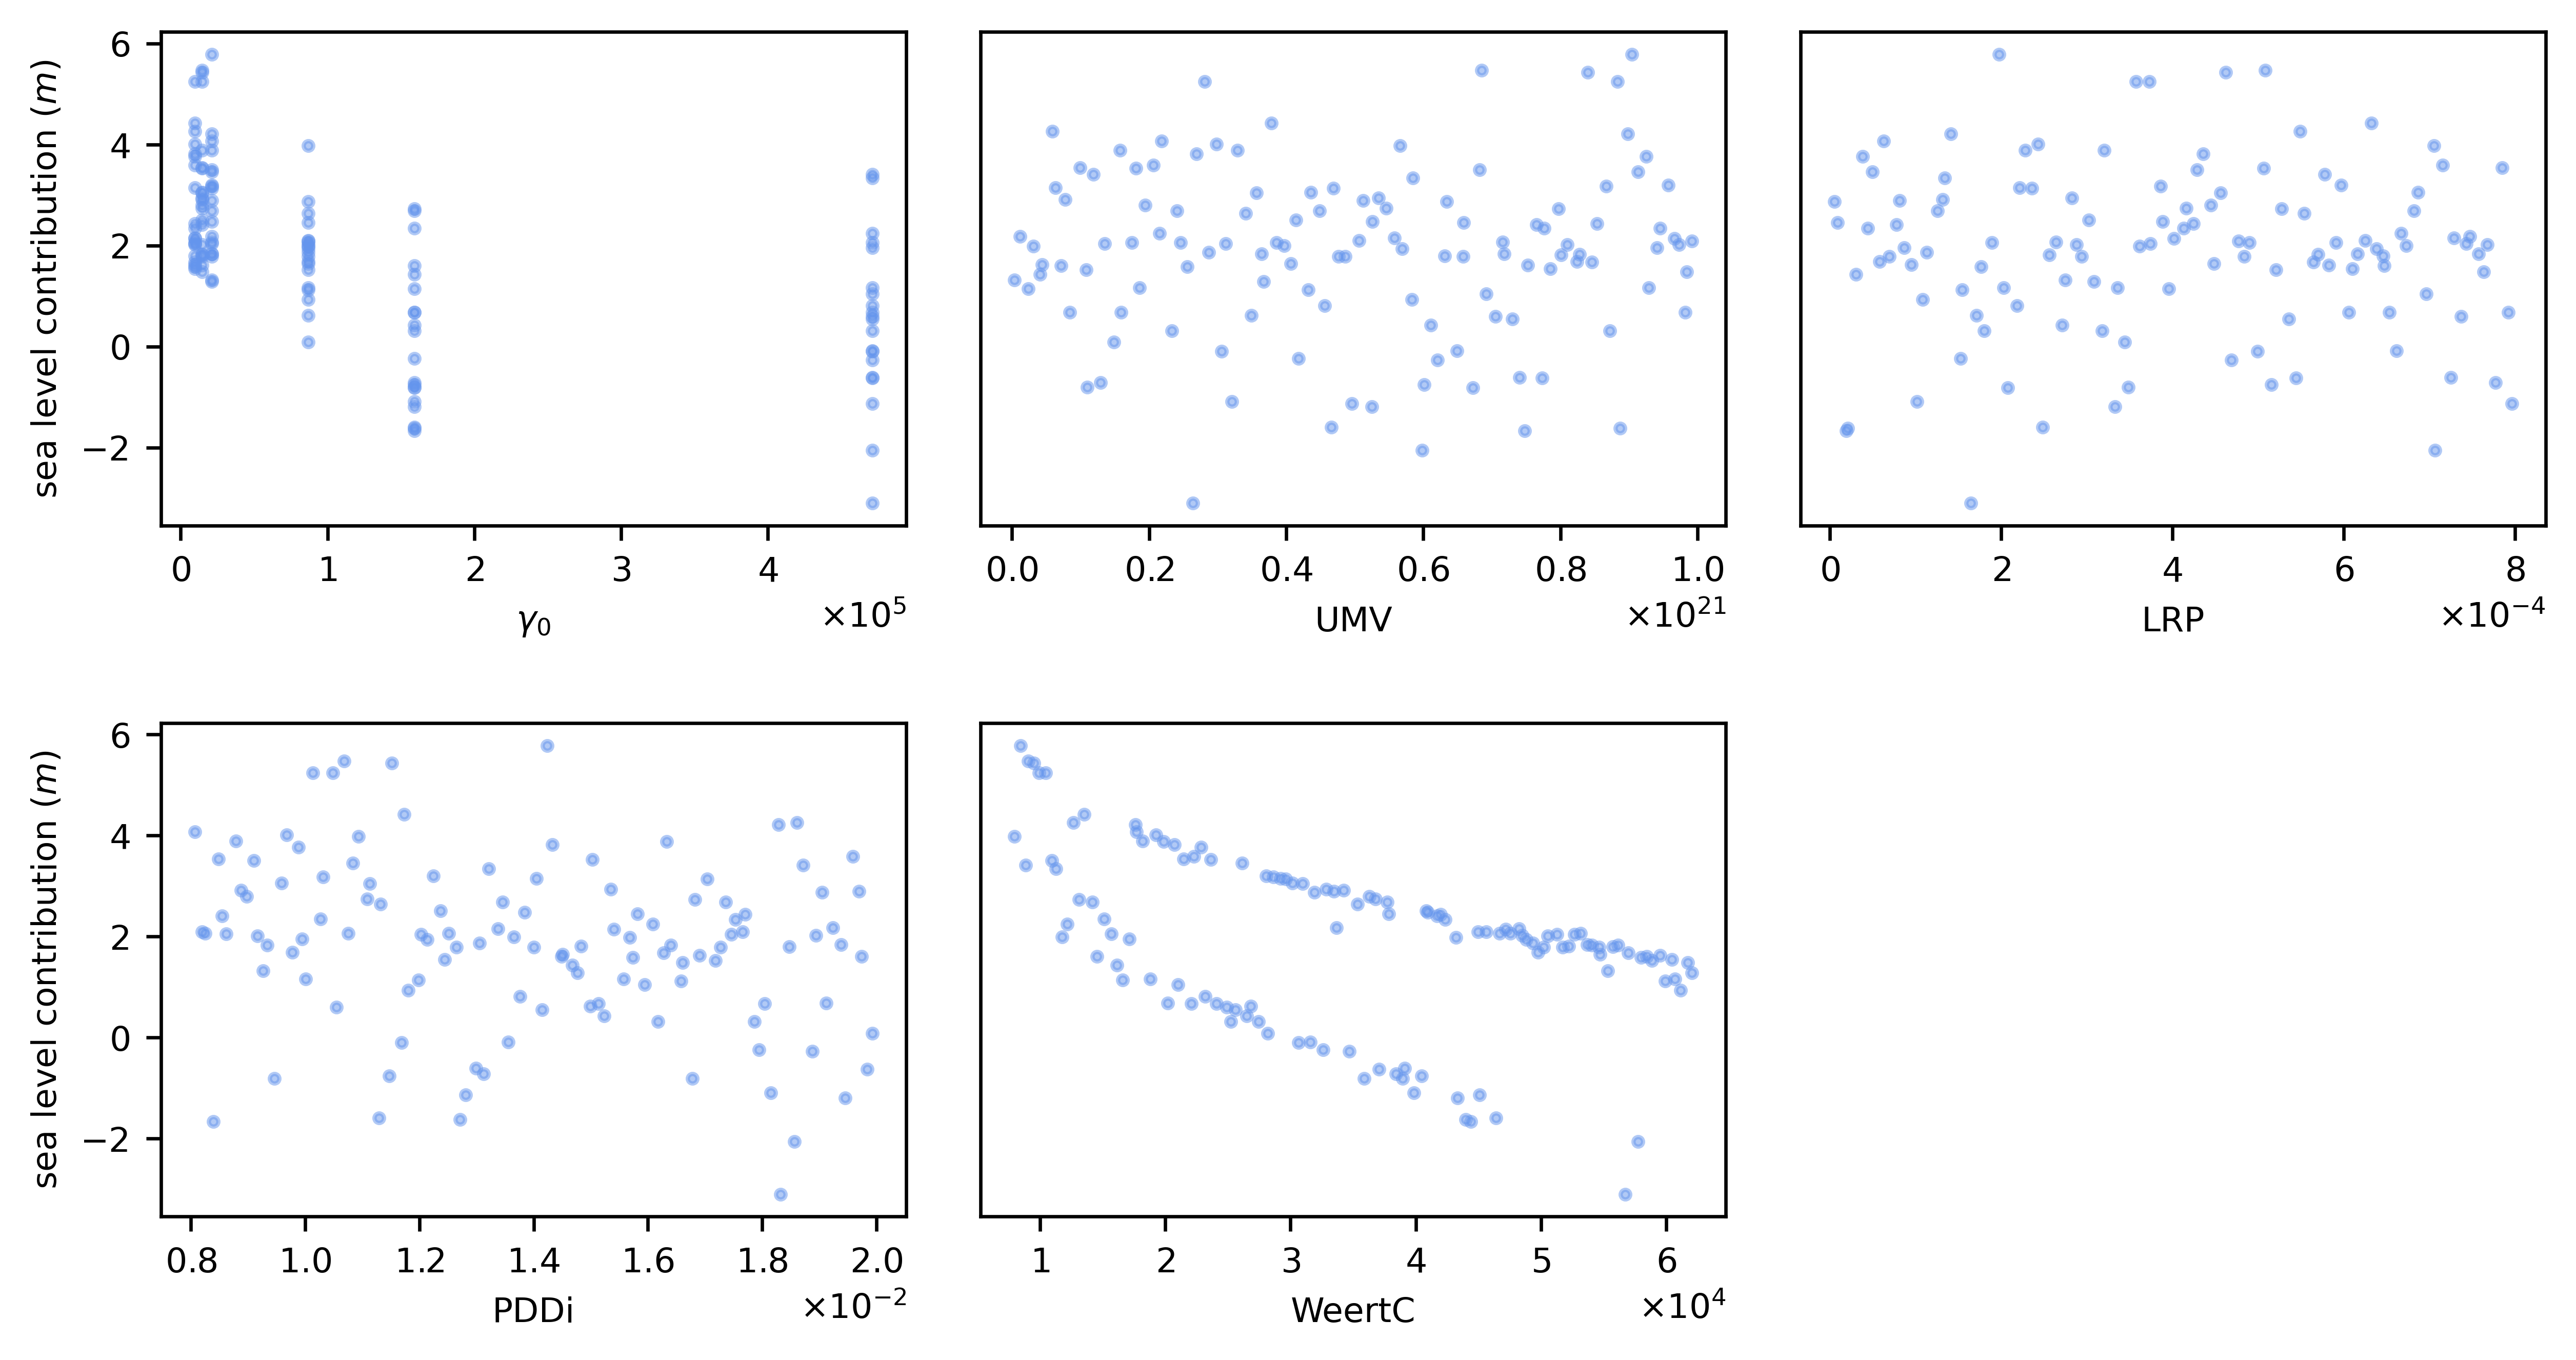

In [53]:
slc = wais.T[333.0]
relabel = {'gamma0': '$\gamma_0$'}
cplot.sensitivity(ppe[parameters], slc, s=5, alpha=0.5, relabel=relabel, color='cornflowerblue')

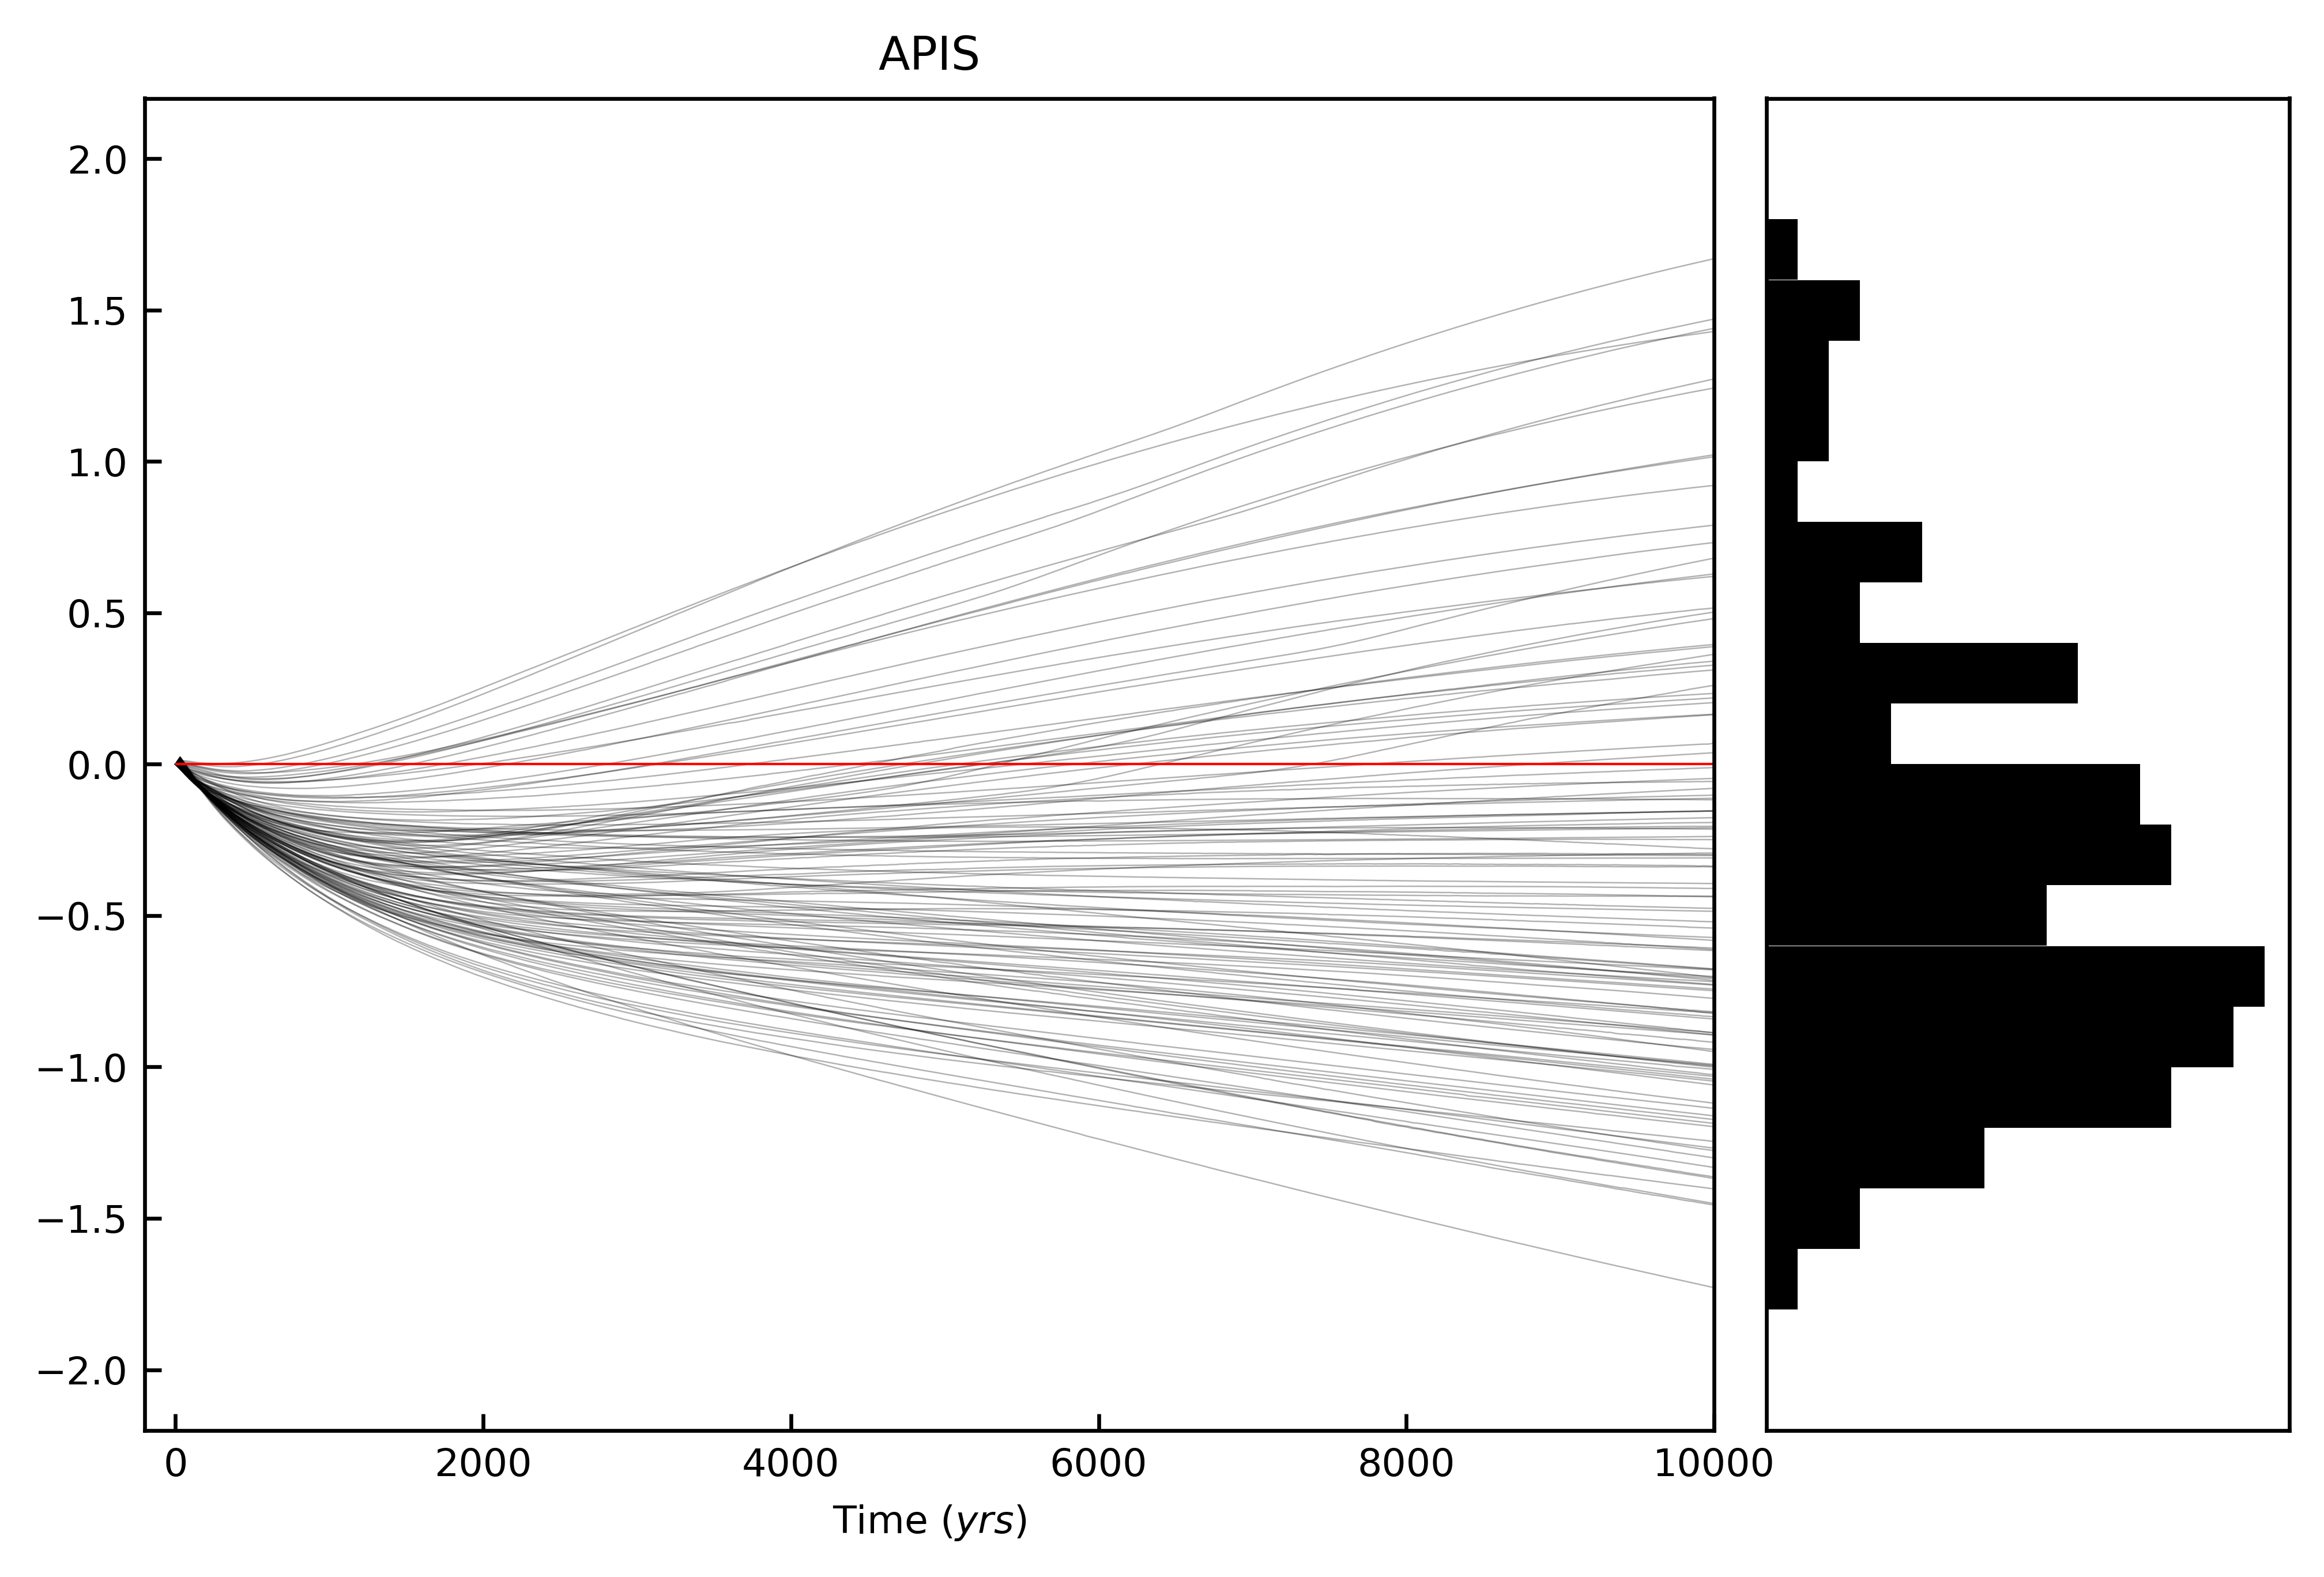

In [73]:
apis = pd.read_csv('ARC/data/AIS_PPE_control_ensemble_APIS.csv', index_col=0, dtype=float)
apis.index = np.arange(0, 10_000, 30)
cplot.ts_with_hist(apis, bin_width=0.2, title='APIS')

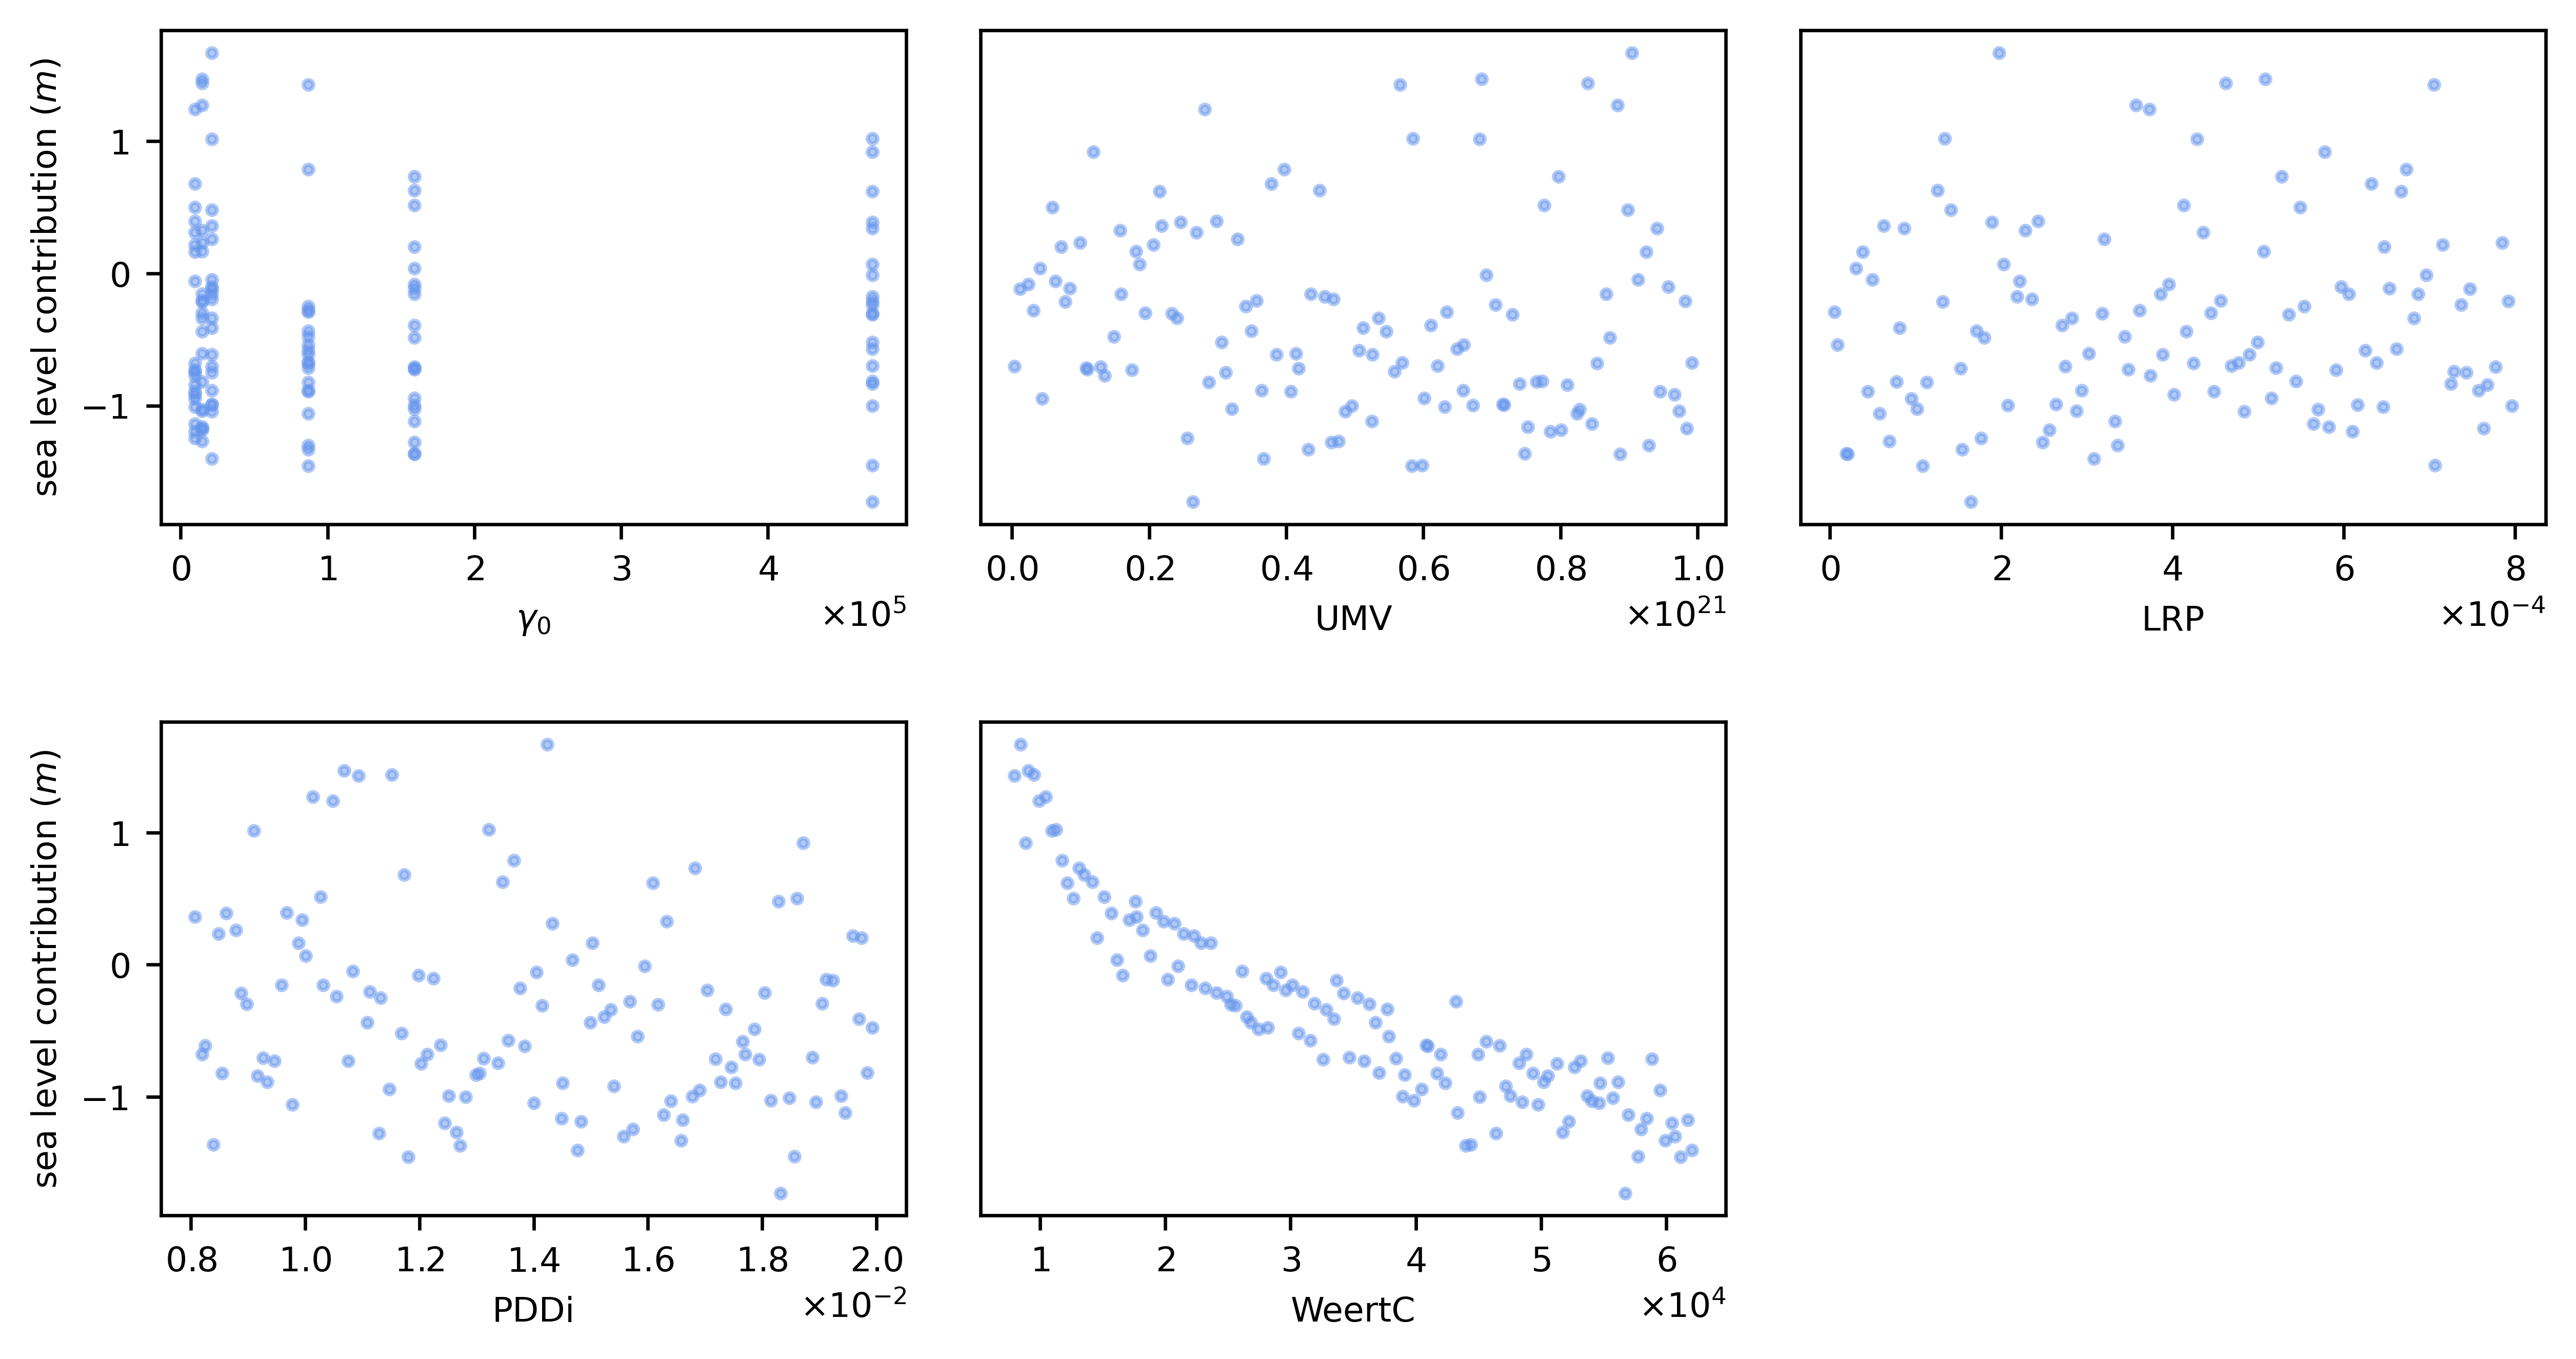

In [68]:
slc = apis.T[9990]
relabel = {'gamma0': '$\gamma_0$'}
cplot.sensitivity(ppe[parameters], slc, s=5, alpha=0.5, relabel=relabel, color='cornflowerblue')